# esmIAV
This code looks at interannual variability in the CESM_ESM (prognostic CO2) simulations
- Read in a .nc file using xarray
- Generate annual anomalies in CO2 growth rate


In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
import esmlab
from ctsm_py import utils
import SVD_tools as svd
import segment as sg
import scipy                    # Try scipy to detrend
from scipy import signal
from scipy.stats import spearmanr
from scipy import stats
import warnings

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

## Read in data

In [2]:
# Point to data
esm = True
varLND = ['TWS','TBOT','NEP','GPP', 'ER','FSDS']  #TWS not available for CESM1 / CLM4
varATM = ['SFCO2'] #['TS','CO2','SFCO2_LND']
var = varLND 
if esm == True:
    var =  var + varATM

In [3]:
if esm == False: 
    # --- CLM5 w/ GSWP3 ---
    model = 'CLM5_GSWP3'
    case  = 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist'
    pattern = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/'+\
        case+'/lnd/proc/tseries/month_1/'+\
        case+'.clm2.h0.{var}.185001-201412.nc'

    file = [pattern.format(var=var) for var in var]
    print(file[0])

    # This is redundant, but for compatability with code below
    fileTWS = file[0]
    fileTBOT= file[1]
    fileNEP= file[2]
    fileGPP= file[3]
    fileER= file[4]

else: 
    times = ['195001-199912','200001-201412']

    # --- CESM2esm (1 ensemble member) ---
    model = 'CESM2_esm_hist1'
    dir_in = '/glade/collections/cdg/timeseries-cmip6/'
    case = 'b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.001'

    # --- CESM1-LENS hist (1 ensemble member) ---
    #model = 'CESM1_LENS1'
    #dir_in = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'
    #case =' b.e11.B20TRC5CNBDRD.f09_g16.001'
    #    '{var}/b.e11.B20TRC5CNBDRD.f09_g16.001.clm2.h0.{var}.185001-200512.nc'

    # Land variables
    pattern_lnd0 = dir_in + case + '/lnd/proc/tseries/month_1/'+case+'.clm2.h0.{varLND}'
    pattern_lnd1 = [pattern_lnd0.format(varLND = varLND) for varLND in varLND]
    # CAM variables
    pattern_atm0 = dir_in + case + '/atm/proc/tseries/month_1/'+case+'.cam.h0.{varATM}'
    pattern_atm1 = [pattern_atm0.format(varATM = varATM) for varATM in varATM]

    # list of strings for each variable & time
    fileTWS = [(pattern_lnd1[0]+'.{times}.nc').format(times=times) for times in times]
    fileTBOT = [(pattern_lnd1[1]+'.{times}.nc').format(times=times) for times in times]
    #fileNBP = [(pattern_lnd1[2]+'.{times}.nc').format(times=times) for times in times]
    fileNEP = [(pattern_lnd1[2]+'.{times}.nc').format(times=times) for times in times]
    fileGPP = [(pattern_lnd1[3]+'.{times}.nc').format(times=times) for times in times]
    fileER = [(pattern_lnd1[4]+'.{times}.nc').format(times=times) for times in times]
    fileFSDS = [(pattern_lnd1[5]+'.{times}.nc').format(times=times) for times in times]
    #fileTS = [(pattern_atm1[0]+'.{times}.nc').format(times=times) for times in times]
    fileCO2 = [(pattern_atm1[0]+'.{times}.nc').format(times=times) for times in times]
    #fileCO2_lnd = [(pattern_atm1[2]+'.{times}.nc').format(times=times) for times in times]
    print(fileFSDS)

['/glade/collections/cdg/timeseries-cmip6/b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.001/lnd/proc/tseries/month_1/b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.001.clm2.h0.FSDS.195001-199912.nc', '/glade/collections/cdg/timeseries-cmip6/b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.001/lnd/proc/tseries/month_1/b.e21.BHIST_BPRP.f09_g17.CMIP6-esm-hist.001.clm2.h0.FSDS.200001-201412.nc']


In [4]:
# Read in files
ds_TWS  = utils.time_set_mid(xr.open_mfdataset(fileTWS, decode_times=False, combine='by_coords'), 'time')
ds_TWS.TWS.attrs['long_name']= 'Terrestrial water storage'
ds_TBOT = utils.time_set_mid(xr.open_mfdataset(fileTBOT, decode_times=False, combine='by_coords'), 'time')
ds_TBOT.TBOT.attrs['long_name']= 'Air temperature'
ds_NEP  = utils.time_set_mid(xr.open_mfdataset(fileNEP, decode_times=False, combine='by_coords'), 'time')
ds_NEP.NEP.attrs['long_name']= 'Net ecosystem production'
ds_GPP  = utils.time_set_mid(xr.open_mfdataset(fileGPP, decode_times=False, combine='by_coords'), 'time')
ds_ER  = utils.time_set_mid(xr.open_mfdataset(fileER, decode_times=False, combine='by_coords'), 'time')
ds_ER.ER.attrs['long_name']= 'Ecosystem respiration'
ds_FSDS  = utils.time_set_mid(xr.open_mfdataset(fileFSDS, decode_times=False, combine='by_coords'), 'time')

ds_time = utils.time_set_mid(xr.open_mfdataset(fileTWS, decode_times=True, combine='by_coords'), 'time')

if esm == True:
    # For CAM output
    #ds_TS = utils.time_set_mid(xr.open_mfdataset(fileTS, decode_times=False,combine='by_coords'), 'time')
    ds_CO2 = utils.time_set_mid(xr.open_mfdataset(fileCO2, decode_times=False,combine='by_coords'), 'time')
    #ds_CO2_lnd = utils.time_set_mid(xr.open_mfdataset(fileCO2_lnd, decode_times=False,combine='by_coords'), 'time')

    #ds_TS['lat'] = ds_TWS.lat # make the dimensions identical for merge
    ds_CO2['lat'] = ds_TWS.lat # make the dimensions identical for merge
    #ds_CO2_lnd['lat'] = ds_TWS.lat # make the dimensions identical for merge
print('------ Read in data ---------')

------ Read in data ---------


### Merge datasets
- Mask out greenland and antarctic for TWS, TBOT, _as in Humphries paper_
- Calculate anomalies & annual means

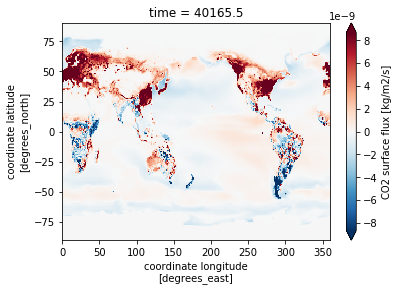

In [5]:
# Merge the datasets
ds = xr.merge([ds_TBOT,ds_TWS,ds_NEP,ds_GPP,ds_ER, ds_FSDS], compat='override')

# add in CO2, here just for the first level of the atmosphere
if esm == True:
    ds = xr.merge([ds, ds_CO2], compat='override')
    ds['SFCO2'] = ds['SFCO2'] *12/44         #SFCO2 kg/m2/s, need to convert to gC/m2/y

minTWS = 10000
# only mask out land variables
for i in range(len(varLND)):
    # here mask out where no GPP instead
    ds[varLND[i]].values = ds[varLND[i]].where(ds_GPP.GPP.max('time')>0)

# mask out area too
ds['area'].values = ds.area.where(ds_GPP.GPP.max('time')>0)
 

#subset years after 1960, last 55 years, global trends look linear after this time (except TWS)
years = 55
months = years * 12
ds = ds.isel(time=slice(-months,None))
ds_time = ds_time.time.isel(time=slice(-months,None))
ds.SFCO2.isel(time=0).plot(robust=True);

### Calculate grid cell anomalies and climatologies

In [6]:
%%time 
# calculate anomalies, climatology & get around error w/ esmlab anomaly when decode_times=True 
ds_anom  = esmlab.core.anomaly(ds, clim_freq='mon', time_coord_name='time') 
ds_clim  = esmlab.core.climatology(ds,freq='mon')    # Calculate climatology

ds['time'] = ds_time.time
ds_anom['time'] = ds_time.time
ds_climSD = ds.groupby('time.month').std('time')

# modify chunk sizes for calculating annual means
ds_anom = ds_anom.chunk({'time': 240}) 

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/indexing.py:1302: PerformanceWarning: Slicing with an out-of-order index is generating 28 times more chunks
  return self.array[key]


CPU times: user 9.93 s, sys: 2.25 s, total: 12.2 s
Wall time: 12.2 s


In [7]:
# calculate annual fluxes for each grid cell
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']  #will be used  throughout
anomUNITS = '(gC $\mathregular{m^{-2}}$ $\mathregular{y^{-1}}$)'
varUNITS = '($\mathregular{gC^{-2}}$ $\mathregular{m^{-4}}$ $\mathregular{y^{-2}}$)'

s2y = 3600 * 24 * 365
ds_ann_temp = utils.weighted_annual_mean(ds[var[0]])
ds_ann = xr.Dataset( coords={'time': ds_ann_temp.time , "lat": ds.lat, "lon": ds.lon} )

for i in range(len(var)):
    ds_ann[var[i]] = utils.weighted_annual_mean(ds[var[i]])
    if (i == 2 or i ==3 or i == 4):
        ds_ann[var[i]] = ds_ann[var[i]]  * s2y
    ds_ann[var[i]].attrs = ds[var[i]].attrs

ds_ann =  ds_ann.where(ds_ann.GPP>50)    #subset  grids  with GPP>50gC/m2
print(ds_ann)
for i in range(3):
    print('Ann '+var[(i+2)]+' Mean = '+str(ds_ann[var[(i+2)]].where(ds_ann.GPP).mean(dim='time').mean().values)+' gC/m2/y')
    print('Ann '+var[(i+2)]+' SD = '+str(ds_ann[var[(i+2)]].where(ds_ann.GPP).std(dim='time').mean().values)+' gC/m2/y')
    print('Ann '+var[(i+2)]+' var = '+str(ds_ann[var[(i+2)]].where(ds_ann.GPP).var(dim='time').mean().values)+' gC/m2/y')
    print('---')

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 55)
Coordinates:
  * time     (time) object 1960-12-16 12:00:00 ... 2014-12-16 12:00:00
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
Data variables:
    TWS      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    TBOT     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    NEP      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    GPP      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ER       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    FSDS     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SFCO2    (time, lat, lon) float64 dask.array<chunksize=(40, 192, 288), meta=np.ndarray>
Ann NEP Mean = 39.458903107757685 gC/m2/y
Ann NEP SD = 41.08705770426423 gC/m2/y
Ann NEP var = 2324.550580367904 gC/m2/y
---
An

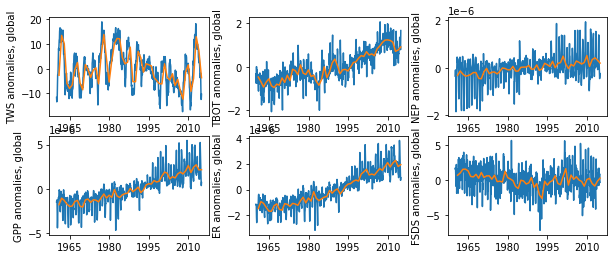

In [8]:
##### caclulate annual averages & quickly look at trends
ds_ann_temp = utils.weighted_annual_mean(ds_anom[var[0]])
ds_ann_anom = xr.Dataset( coords={'time': ds_ann_temp.time , "lat": ds_anom.lat, "lon": ds_anom.lon} )

plt.figure(figsize=[10,4])
for i in range(len(var)):
    ds_anom[var[i]].attrs['long_name'] = ds_anom[var[i]].attrs['long_name'] + ' anomaly' 
    ds_ann_anom[var[i]] = utils.weighted_annual_mean(ds_anom[var[i]]) 
    ds_ann_anom[var[i]].attrs = ds_anom[var[i]].attrs
    # trends after 1960 look good for all but TWS, just make one plot for efficiency here
    if (i<6):  
        plt.subplot(2, 3, (1+i))
        plt.ylabel(var[i] + ' anomalies, global')
        plt.plot(ds_anom.time, ds_anom[var[i]].mean(dim=('lat','lon')))
        plt.plot(ds_ann_anom.time, ds_ann_anom[var[i]].mean(dim=('lat','lon')))
        plt.ticklabel_format(axis='y', style='', scilimits=(-2,2))
    if (i>1 and i<5 or i==6):
        ds_ann_anom[var[i]] = ds_ann_anom[var[i]] * s2y
        ds_ann_anom[var[i]].attrs['units'] = anomUNITS
plt.subplots_adjust(wspace=0.25);

#### Plot grid cell variances & GPP vs. Reco anomalies
similar to plots in Baldocchi et al (2018) Ag For Met https://doi:10.1016/j.agrformet.2017.05.015

In [9]:
ds_ann_var = ds_ann.var(dim='time')
ds_ann_var  =  ds_ann_var.where(ds_ann_var.GPP>0)

temp = ds_ann_anom.where(ds_ann.GPP>50).std(dim='time')
for i in range(2,5):
    print(var[i])
    print('mean of annual = '+str(ds_ann[var[(i)]].where(ds_ann.GPP).mean(dim='time').mean().values)+' gC/m2/y')
    print('mean sigma of ann anom = '+str(temp[var[i]].mean().values) )

# variance correlation
x1 = ds_ann_var.GPP.to_dataframe().dropna(how='all')['GPP'].to_numpy()
x2 = ds_ann_var.ER.to_dataframe().dropna(how='all')['ER'].to_numpy()
y = ds_ann_var.NEP.to_dataframe().dropna(how='all')['NEP'].to_numpy()
r1 = stats.linregress(np.log10(x1), np.log10(y)) #slope, intercept, r_value, p_value, std_err
r2 = stats.linregress(np.log10(x2), np.log10(y))

# anomaly covariance
x3 = ds_ann_anom.GPP.to_dataframe().dropna(how='all')['GPP'].to_numpy()
y3 = ds_ann_anom.ER.to_dataframe().dropna(how='all')['ER'].to_numpy()
r3 = stats.linregress(x3, y3)

print(r1)
print(r2)
print(r3)

NEP
mean of annual = 39.458903107757685 gC/m2/y
mean sigma of ann anom = 41.08705770433817
GPP
mean of annual = 949.7983965613942 gC/m2/y
mean sigma of ann anom = 118.72082656685178
ER
mean of annual = 910.3394934392863 gC/m2/y
mean sigma of ann anom = 100.28282564458702
LinregressResult(slope=0.7672097272638725, intercept=0.0016851335923799837, rvalue=0.7872534087736945, pvalue=0.0, stderr=0.005578053043007072)
LinregressResult(slope=0.7215842866351048, intercept=0.2945900078075252, rvalue=0.7428508524587023, pvalue=0.0, stderr=0.006036244382494226)
LinregressResult(slope=0.7953162540066364, intercept=6.804410885949647e-07, rvalue=0.9416371053877117, pvalue=0.0, stderr=0.0003391537076193733)


GPP variance median = 11688.321336028348
GPP ~ ER anom slope = 0.8 r = 0.94
GPP variance median = 19435.224043882637


<Figure size 504x288 with 0 Axes>

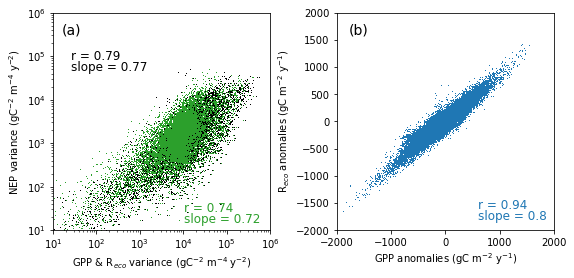

In [10]:
plt.figure(figsize=(7, 4))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))#,sharey=True)
fig.subplots_adjust(wspace=0.3)

ax1.set_xscale("log")
ax1.set_yscale("log")
xlim = (1e1, 1e6)
ylim = xlim
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.plot(x1, y,',', color='k')
ax1.plot(x2, y,',', color='tab:green')
#ax1.hexbin(x1,y, cmap='Greys',xscale='log',yscale='log',bins='log',extent=(1,6,1,6))
#ax1.hexbin(x2,y, cmap='Greens',xscale='log',yscale='log',bins='log',extent=(1,6,1,6))
ax1.set_ylabel('NEP variance '+varUNITS)
ax1.set_xlabel('GPP & R$_{eco}$ variance '+varUNITS)
ax1.text(-1.22, 0.92,panel[0], fontsize=14,
                 ha='center', va='center', transform=plt.gca().transAxes)

ax1.text(-1.22, 0.80,'r = '+str(np.round(r1[2],2)),fontsize=12, color='k',
         ha='left', va='center', transform=plt.gca().transAxes)
ax1.text(-1.22, 0.75,'slope = '+str(np.round(r1[0],2)), fontsize=12, color='k',
        ha='left', va='center', transform=plt.gca().transAxes)
ax1.text(-0.7, 0.1,'r = '+str(np.round(r2[2],2)),fontsize=12, color='tab:green',
        ha='left', va='center', transform=plt.gca().transAxes)
ax1.text(-0.7, 0.05,'slope = '+str(np.round(r2[0],2)),fontsize=12, color='tab:green',
        ha='left', va='center', transform=plt.gca().transAxes);
ax1.set_aspect(1)

print('GPP variance median = '+str(np.median(x1)))
print('GPP ~ ER anom slope = '+str(np.round(r3[0],2))+' r = '+str(np.round(r3[2],2)))
print('GPP variance median = '+str(np.mean(x1)))

ax2.plot(x3, y3, ",",color='tab:blue')
xlim = (-2e3, 2e3)
ylim = xlim
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_ylabel('R$_{eco}$ anomalies '+anomUNITS)
ax2.set_xlabel('GPP anomalies '+anomUNITS)
ax2.text(0.1, 0.92,panel[1], fontsize=14,
                 ha='center', va='center', transform=plt.gca().transAxes)
ax2.text(xlim[1]*0.3,ylim[0]*0.8,'r = '+str(np.round(r3[2],2)),fontsize=12, color='tab:blue')
ax2.text(xlim[1]*0.3,ylim[0]*0.9,'slope = '+str(np.round(r3[0],2)),fontsize=12, color='tab:blue');

ax2.set_aspect(1);
plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_2b_GridClimCorr.eps');
plt.show();

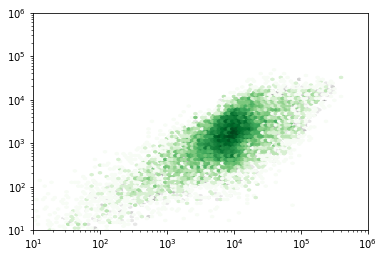

In [11]:
# suggestion to make hexbin plots, but how to overlay isn't clear?
plt.hexbin(x1,y, cmap='Greys',xscale='log',yscale='log',bins='log',extent=(1,6,1,6),mincnt=1)
plt.hexbin(x2,y, cmap='Greens',xscale='log',yscale='log',bins='log',extent=(1,6,1,6),mincnt=1);

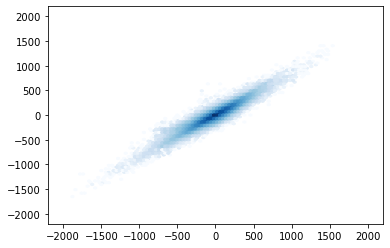

In [12]:
plt.hexbin(x3,y3, cmap='Blues',bins='log',extent=(-2000,2000,-2000,2000),mincnt=1);

### Weight grid cell fluxes to global sums

In [13]:
# area only for land
lat = ds.lat
lon = ds.lon
nlat = len(lat)
nlon = len(lon)

In [14]:
# for weighting in globalSum function, below
if (model == 'CLM5_GSWP3'):
    land_up = ds.area * ds.landfrac #km^2

if (model == 'CESM2_esm_hist1'):
    land_up = (ds.area.isel(time=0) * ds.landfrac.isel(time=0)) #km^2

land_wgt = land_up / land_up.sum(dim=('lat','lon'))
land_area = land_up.values * 1e6  # convert km2 to m2

# NEED to calculate grid areas for atm results, from Katie's Weighted Means example
if esm==True:
    R = 6.37e6
    # we know already that the spacing of the points is 180/nlat & 360/nlon
    dϕ = np.deg2rad(180/nlat)
    dλ = np.deg2rad(360/nlon)
    dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat))

    dA.where(ds.SFCO2.isel(time=0).notnull())
    pixel_area = dA.where(ds.SFCO2.isel(time=0).notnull())
    pixel_area.attrs['units'] = 'm2'
    pixel_area.attrs['long_name'] = 'grid area'
    pixel_wgt = pixel_area / pixel_area.sum()

## Define function for global mean

In [15]:
# need to remove the stonrg annual cycle 
# positive flux = source to atmosphere
def globalSum ( varIn, area, time, conversion, units ):
    "Global weighted sum of fluxes & states"
    temp = varIn * area * time
    temp = temp.sum(dim=('lat','lon'))  * conversion
    temp.attrs['long_name']= varIn.attrs['long_name']
    temp.attrs['units']= units
    #temp = temp.assign_coords({'time': (ds.time)})
    return (temp)

For each variable, Create lists of input needed fro globalSum function: 
- [varIn, area, time, conversion, units]

In [16]:
trop = ds_ann_anom.where(lat>-23)
trop = trop.where(lat<23)

starting TWS
starting TBOT
starting NEP
starting GPP
starting ER
starting FSDS
starting SFCO2


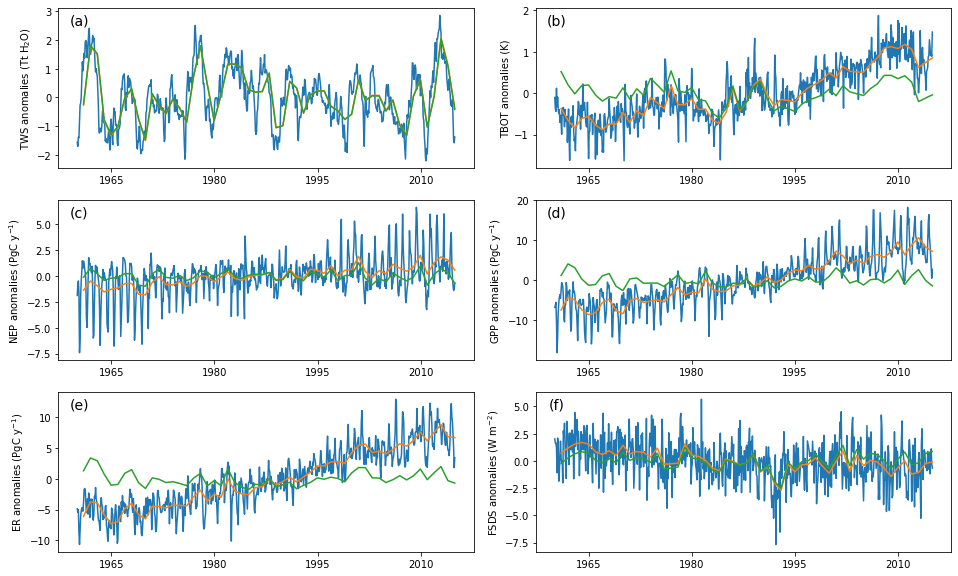

In [17]:
if esm==True:
    Area = [land_area, land_wgt, land_area, land_area, land_area, land_wgt, pixel_area]#, pixel_area, pixel_area]
    Time = [1, 1, s2y, s2y, s2y, 1, s2y]#, s2y, s2y]   
    ## 1 mm water = 1 kg/m2,  1e-15 for kg to Tt,  1e-15 gC to PgC, 1e-12 kgC to PgC
    Conversion = [1e-15, 1, 1e-15, 1e-15, 1e-15, 1, 1e-12]#, 1, 1e-12, 1e-12]   
    Units = ['Tt $\mathregular{H_2O}$', 'K', 'PgC $\mathregular{y^{-1}}$',
             'PgC $\mathregular{y^{-1}}$', 'PgC $\mathregular{y^{-1}}$', 
             'W $\mathregular{m^{-2}}$', 'PgC $\mathregular{y^{-1}}$']

else:
    Area = [land_area, land_wgt, land_area, land_area, land_area]#, pixel_wgt, pixel_area, pixel_area]
    Time = [1, 1, s2y, s2y, s2y]#, 1, s2y, s2y]   
    Conversion = [1e-15, 1, 1e-15, 1e-15, 1e-15]#, 1, 1e-12, 1e-12]   
    Units = ['Tt $\mathregular{H_2O}$', 'K', 'PgC $\mathregular{y^{-1}}$',
             'PgC $\mathregular{y^{-1}}$', 'PgC $\mathregular{y^{-1}}$']

plt.figure(figsize=[16,10])

# Create datasets for results.  Anomalies # detrended
#region = ['global','tropics']
anom = xr.Dataset( coords={'time': ds_anom.time} )
ann_anom = xr.Dataset( coords={'time': ds_ann_anom.time} )
ann_anom_tropics = xr.Dataset( coords={'time': ds_ann_anom.time} )
anom_dt = xr.Dataset( coords={'time': ds_anom.time} )
ann_anom_dt = xr.Dataset( coords={'time': ds_ann_anom.time} )
ann_anom_dt_tropics = xr.Dataset( coords={'time': ds_ann_anom.time} )
#then loop through variables
for i in range(len(var)):
    print('starting ' +var[i])
    anom[var[i]] =  globalSum(ds_anom[var[i]], area = Area[i], time = Time[i], 
                              conversion = Conversion[i], units = Units[i] )
    #  ds_ann_anom already  converted to gC/m2/y
    ann_anom[var[i]] =  globalSum(ds_ann_anom[var[i]], area = Area[i], time = 1, 
                                     conversion = Conversion[i], units = Units[i] )
    ann_anom_tropics[var[i]] =  globalSum(trop[var[i]], area = Area[i], time = 1,
                                          conversion = Conversion[i], units = Units[i] )
    # detrended results
    anom_dt[var[i]] = xr.DataArray(signal.detrend(anom[var[i]]), dims='time')
    ann_anom_dt[var[i]] = xr.DataArray(signal.detrend(ann_anom[var[i]]), dims='time')
    ann_anom_dt_tropics[var[i]] = xr.DataArray(signal.detrend(ann_anom_tropics[var[i]]), dims='time')
    # copy attributes
    anom_dt[var[i]].attrs = anom[var[i]].attrs
    ann_anom_dt[var[i]].attrs = ann_anom[var[i]].attrs
    ann_anom_dt_tropics[var[i]].attrs = ann_anom[var[i]].attrs
    # modify long_names
    ann_anom_dt_tropics[var[i]].attrs['long_name'] = 'Tropical ' + ann_anom_dt_tropics[var[i]].attrs['long_name']
    if (i<6):
        plt.subplot(3, 2, (1+i))
        plt.ylabel(var[i] + ' anomalies ('+anom[var[i]].attrs['units']+')')
        plt.plot(anom.time, anom[var[i]])
        plt.plot(ann_anom.time, ann_anom[var[i]])
        plt.plot(ann_anom_dt.time, ann_anom_dt[var[i]])
        plt.ticklabel_format(axis='y', style='', scilimits=(-2,2))
        plt.text(0.05, 0.92,panel[i], fontsize=14,
                 ha='center', va='center', transform=plt.gca().transAxes)

            
plt.subplots_adjust(wspace=0.15);
plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_S1_globalTrends.eps');

#### Still significant trend in monthly C flux anomalies 
Drill into NEP & SFCO2 anom. and compare to variability in atmosperic CO2 growth rate from GCP

AGR data from Friedlingstein et al Earth Syst. Sci. Data, 2019. https://doi.org/10.5194/essd-11-1783-2019

CESM2_esm_hist1 std NEP 0.4700737280045149
GCP_AGR std 0.9461043985342277
CESM2_esm_hist1 std TWS 0.8182467077687282
CESM2_esm_hist1 std Tropical TBOT 0.10373493466977039


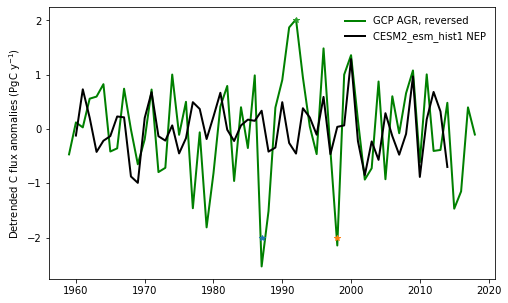

In [18]:
from pandas import read_csv
import cftime

gcp = read_csv('/glade/p/cgd/tss/people/wwieder/outside_data/GCP_19_summary.csv')
gcpDT = signal.detrend(gcp.atmospheric_growth)

plt.figure(figsize=[8,5])
plt.ylabel('Detrended C flux anomalies ('+ann_anom_dt[var[2]].attrs['units']+')')
plt.ticklabel_format(axis='y', style='', scilimits=(-2,2))
plt.plot(gcp.Year, -gcpDT,'g-', lw=2);
plt.plot(ann_anom_dt['time.year'], ann_anom_dt[var[2]],'k-',lw=2)
plt.plot(1987, -2,'*')
plt.plot(1998, -2,'*')
plt.plot(1992, 2,'*')

labels = ['GCP AGR, reversed',str(model+' '+var[2])]    
plt.legend(labels=labels, frameon=False);

print(model+' std '+var[2]+' '+str(ann_anom_dt[var[2]].std().values))
print('GCP_AGR std '+str(gcpDT.std()))
print(model+' std '+var[0]+' '+str(ann_anom_dt[var[0]].std().values))
print(model+' std Tropical '+var[1]+' '+str(ann_anom_dt_tropics[var[1]].std().values));

### Plot correlations in annual fluxes vs. climate: 
- Time series and scatter plots

In [19]:
from scipy import signal,stats
from sklearn.linear_model import LinearRegression

# Generate a function for making panel plots of maps

def scatter_function(X, Y, xlab=True, col='k', pos=1):#cb=0, cmap=None, ax=None, title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    x= X.values
    y= Y.values
    y2 = y#np.where(y<10, y, np.nan)
    model = LinearRegression().fit(x.reshape((-1, 1)), y2)
    R, p = stats.pearsonr(x,y)
    R = np.round(R, 2)
    slope = np.round(model.coef_,2)[0]
    print('p = '+str(p))
    
    xRange = np.array([x.min(),x.max()]).reshape(-1, 1)
    yPred = model.predict(xRange)
    yRange= np.array([y.min(),y.max()]).reshape(-1, 1)
    #print(yRange)
    xlim=xRange*1.1
    ylim=yRange*1.
    plt.plot(x, y,'o',color=col)
    plt.plot(xRange,yPred,color=col)
    if (pos==1): #upper left
        plt.text(xlim[0]*0.8,ylim[1]*0.9,'r = '+str(R),fontsize=12, color=col)
        plt.text(xlim[0]*0.8,ylim[1]*0.8,'slope = '+str(slope),fontsize=12, color=col);
    if (pos==2): #upper right
        plt.text(xlim[1]*0.6,ylim[1]*0.9,'r = '+str(R),fontsize=12, color=col)
        plt.text(xlim[1]*0.6,ylim[1]*0.8,'slope = '+str(slope),fontsize=12, color=col);
    if (pos==3): #lower right
        plt.text(xlim[1]*0.6,ylim[0]*0.8,'r = '+str(R),fontsize=12, color=col)
        plt.text(xlim[1]*0.6,ylim[0]*0.9,'slope = '+str(slope),fontsize=12, color=col);
    plt.xlim(xlim)
    #plt.ylim(-4.2,3.5)
    if xlab == True:  
        xlab = X.attrs['long_name']
    else:
        xlab = xlab
    plt.ylabel(Y.attrs['long_name']+' ('+Y.attrs['units']+')')
    plt.xlabel(xlab +' ('+X.attrs['units']+')')
        

<Figure size 864x576 with 0 Axes>

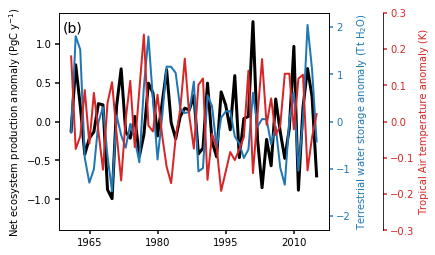

In [20]:
# put timeseries (Fig  1b) onto a single plot
# modified from https://matplotlib.org/3.1.1/gallery/ticks_and_spines/multiple_yaxis_with_spines.html
# Todo, it woudl be nice to make all 4 panels at onece with this.
plt.figure(figsize=[12,8])

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, host = plt.subplots()
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot(ann_anom_dt.time, ann_anom_dt.NEP, 'k-', label= 'NEP',lw=3)
p2, = par1.plot(ann_anom_dt.time, ann_anom_dt.TWS, 'tab:blue', label='TWS',lw=2)
p3, = par2.plot(ann_anom_dt.time, ann_anom_dt_tropics.TBOT, 'tab:red', label='TBOT',lw=2)

#host.set_xlim(1960, 2015)
host.set_ylim(-1.4, 1.4)
par1.set_ylim(-2.3, 2.3)
par2.set_ylim(-0.3, 0.3)

#host.set_xlabel("Distance")
host.set_ylabel(ann_anom_dt.NEP.attrs['long_name']+' ('+ann_anom_dt.NEP.attrs['units']+')')
par1.set_ylabel(ann_anom_dt.TWS.attrs['long_name']+' ('+ann_anom_dt.TWS.attrs['units']+')')
par2.set_ylabel(ann_anom_dt_tropics.TBOT.attrs['long_name']+' ('+ann_anom_dt.TBOT.attrs['units']+')')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]
host.text(0.05, 0.93,panel[1], fontsize=14,
         ha='center', va='center', transform=plt.gca().transAxes);

plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_1b.eps');

p = 2.1402364354661748e-07
p = 4.369250483192389e-06


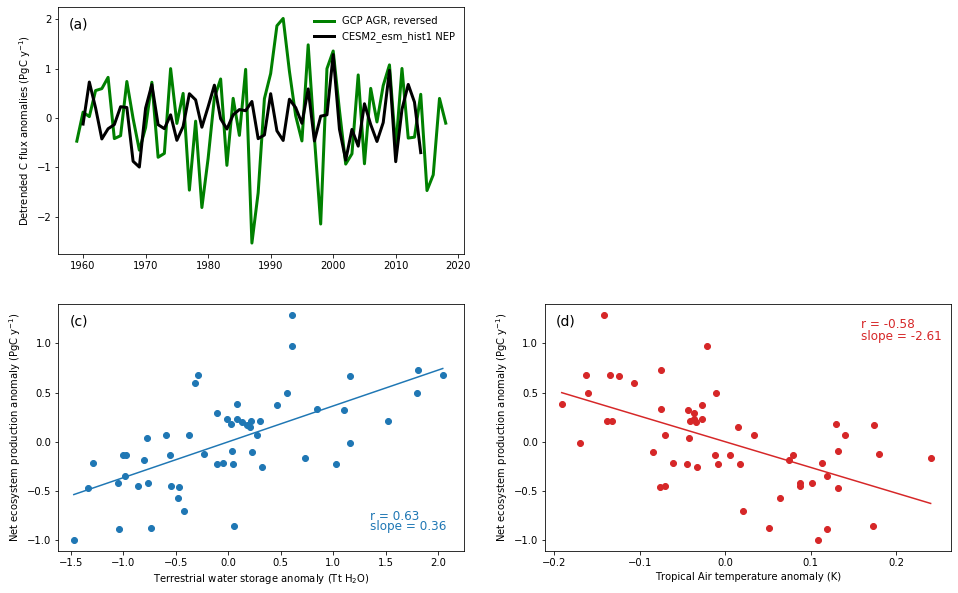

In [21]:
# now make Fig 1a,c,d  all on one  plot
plt.figure(figsize=[16,10])
plt.subplot(221);
plt.ylabel('Detrended C flux anomalies ('+ann_anom_dt[var[2]].attrs['units']+')')
plt.ticklabel_format(axis='y', style='', scilimits=(-2,2))
plt.plot(gcp.Year, -gcpDT,'g-', lw=3);
plt.plot(ann_anom_dt['time.year'], ann_anom_dt[var[2]],'k-',lw=3)
plt.text(0.05, 0.93,panel[0], fontsize=14,
         ha='center', va='center', transform=plt.gca().transAxes)
labels = ['GCP AGR, reversed',str(model+' '+var[2])]    
plt.legend(labels=labels, frameon=False);

plt.subplot(223);
scatter_function(ann_anom_dt.TWS, ann_anom_dt.NEP,col='tab:blue',pos=3)
plt.text(0.05, 0.93,panel[2], fontsize=14,
         ha='center', va='center', transform=plt.gca().transAxes)

plt.subplot(224);
scatter_function(ann_anom_dt_tropics.TBOT, ann_anom_dt.NEP,col='tab:red',pos=2)
plt.text(0.05, 0.93,panel[3], fontsize=14,
         ha='center', va='center', transform=plt.gca().transAxes);

plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_1acd.eps');

- NEP positive correlation w/ TWS, with with lower slope and r than Humphrey et al 2018 (r = -0.85, slope = -1.3 PgC y^-1/Tt H2O)
- NEP negative correlation w/ Tropical TBOT, with lower slope and r than Cox et al. 2013(r =  0.65, slope = -5.1 PgC y^-1/K)
- no relationship with global FSDS (not shown)
- Make some extra plots to look at global & tropical variability

p = 1.0417846782043149e-11
p = 5.777450108240765e-08
p = 1.0685199458360097e-11
p = 4.369250483192389e-06
p = 8.250314079862797e-19
p = 3.6796234122970385e-11
p = 6.589964393303799e-09
p = 0.019102094649299194


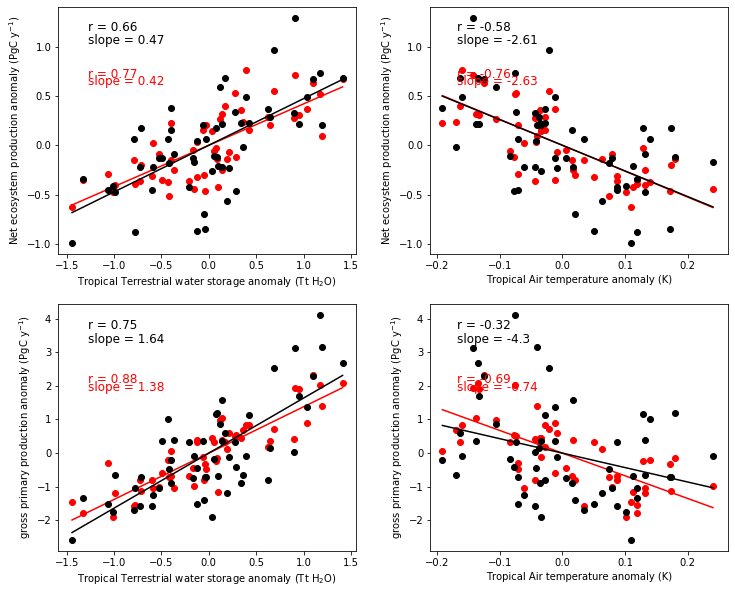

In [22]:
# global C flux w/ tropical TWS & TBOT = black
# tropical C flux w/ tropical TWS & TBOT = red
var_flux = ('NEP','GPP')
plt.figure(figsize=[12,10])
for i in range(len(var_flux)) :        
    plt.subplot(len(var_flux), 2, (2*i+1))
    scatter_function(ann_anom_dt_tropics.TWS, ann_anom_dt_tropics[var_flux[i]],col='r')
    scatter_function(ann_anom_dt_tropics.TWS, ann_anom_dt[var_flux[i]],col='k')
    plt.subplot(len(var_flux), 2, (2*i+2))
    scatter_function(ann_anom_dt_tropics.TBOT, ann_anom_dt_tropics[var_flux[i]],col='r')
    scatter_function(ann_anom_dt_tropics.TBOT, ann_anom_dt[var_flux[i]],col='k')

plt.subplots_adjust(wspace=0.25);

#### Tropical GPP anomalies bettter fit with TWS than TBOT, similar for NEP

p = 1.0417846782043149e-11
p = 1.0685199458360097e-11
p = 8.250314079862797e-19
p = 6.589964393303799e-09


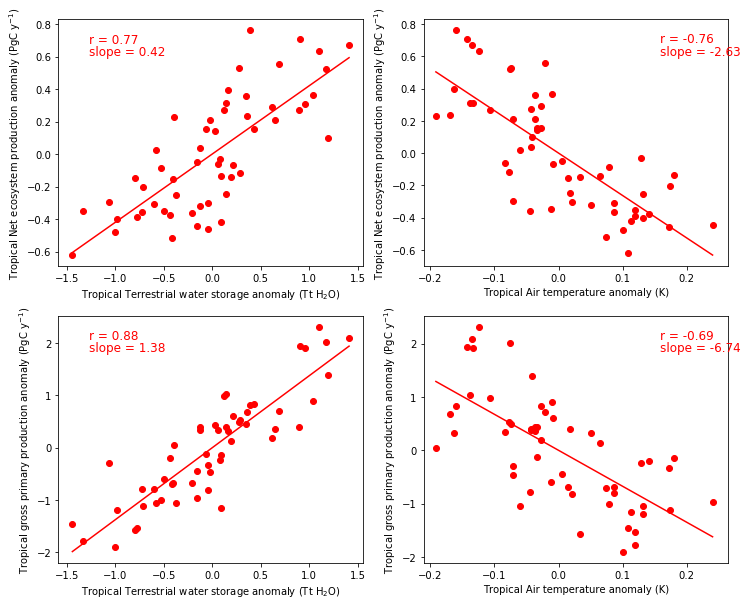

In [23]:
plt.figure(figsize=[12,10])
for i in range(len(var_flux)) :        
    plt.subplot(len(var_flux), 2, (2*i+1))
    scatter_function(ann_anom_dt_tropics.TWS, ann_anom_dt_tropics[var_flux[i]], col='r')
    plt.subplot(len(var_flux), 2, (2*i+2))
    scatter_function(ann_anom_dt_tropics.TBOT, ann_anom_dt_tropics[var_flux[i]], pos=2, col='r')

p = 0.00018554957635778224
p = 7.310384469574887e-10
p = 4.361046065433784e-30
 SD annual NEP anomalies = 0.47 Pg C y^-1 
 SD annual GPP anomalies = 1.414 Pg C y^-1 


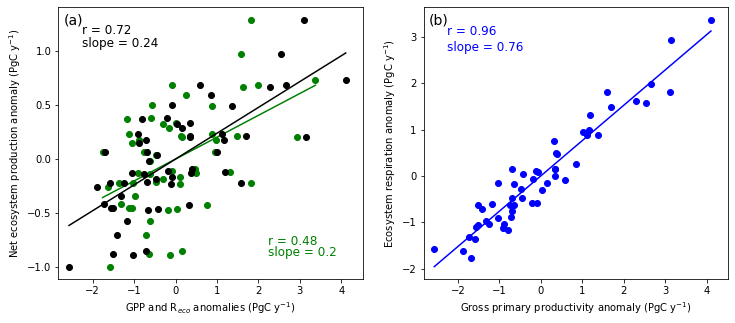

In [24]:
#scatter_function(ann_anom_dt_tropics.GPP, ann_anom_dt_tropics.NEP,col='r')
plt.figure(figsize=[12,5])
plt.subplot(121)
scatter_function(ann_anom_dt.ER, ann_anom_dt.NEP, col='g',pos=3, 
                 xlab='Gross flux anomalies')
scatter_function(ann_anom_dt.GPP, ann_anom_dt.NEP, xlab=r'GPP and R$_{eco }$ anomalies')
plt.text(0.05, 0.95,panel[0], fontsize=14,
         ha='center', va='center', transform=plt.gca().transAxes)

plt.subplot(122)
scatter_function(ann_anom_dt.GPP, ann_anom_dt.ER, col='b', pos =  1,
                 xlab='Gross primary productivity anomaly')
plt.text(0.05, 0.95,panel[1], fontsize=14,
         ha='center', va='center', transform=plt.gca().transAxes)
plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_2_GlobalClimCorr.eps')

print(' SD annual NEP anomalies = ' +
      str(np.round(ann_anom_dt[var[2]].std().values,3))+ 
      ' Pg C y^-1 ')#'*omitting outlier')
print(' SD annual GPP anomalies = ' +
      str(np.round(ann_anom_dt[var[3]].std().values,3))+ 
      ' Pg C y^-1 ')

#### GLOBAL NEP anomalies more strongly correlated with GPP than ER, as in Baldocchi's Ameriflux paper (2018)
- Baldocchi actually look at tower site variance in NEE and component fluxes (see above). 
- Higher IAV for GPP, but of similar magnitude to IAV of CO2 growth rate (Piao et al. 2019, 1PgC/y)
- Below, Monthly anomalies well constrained for TWS, larger for C fluxes

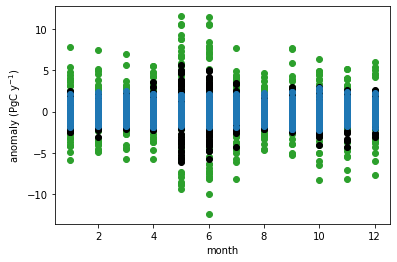

In [25]:
# GPP anomalies largely related to spring GPP 
plt.plot(anom_dt.time['time.month'], anom_dt.GPP, 'o', color='tab:green')
plt.plot(anom_dt.time['time.month'], anom_dt.NEP, 'o', color='k')
plt.plot(anom_dt.time['time.month'], anom_dt.TWS, 'o', color='tab:blue')
plt.ylabel('anomaly ('+ann_anom_dt.NEP.attrs['units']+')')
plt.xlabel('month');

## Plot spatial correlations between annual anomalies of C fluxes & climate

In [26]:
# Generate a function for making panel plots of maps
def map_function(da, cb=0, panel=None, cmap=None, ax=None, 
                 title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180,180,-65,80], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.95), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # allows for different colorbars on each plot
    if cb == 1:
        fig.colorbar(im, ax=ax,shrink=0.40, pad=0, fraction = 0.1)

## Need to remove trends to really look at correlations of IAV

In [27]:
# Define functiion to handle detrending
def dtrend(anom, dim):
    # note: apply always moves core dimensions to the end
    return xr.apply_ufunc(signal.detrend, anom,
                       input_core_dims=[[dim]],
                       output_core_dims=[[dim]],
                       kwargs={'axis': -1})

# store results
dt_ann_anom = xr.Dataset( coords={'time': ds_ann_anom.time, "lat": ds.lat, "lon": ds.lon} )
# loop over variables
for i in range(len(var)):
    dt_ann_anom[var[i]] = dtrend(ds_ann_anom[var[i]].load().fillna(0), 'time')

[1.18868040e-05 3.99445469e-05 1.30150283e-05 ... 1.30176597e-05
 6.72190037e-06 4.66828373e-06]
mean r = 0.5930721996032251


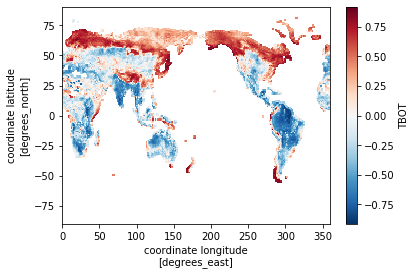

In [28]:
import corrFunc as cor
# Calculate orrelations with detrended anomalies
GPP_DTann_corr = xr.Dataset( coords={"lat": ds.lat, "lon": ds.lon} )
NEP_DTann_corr = xr.Dataset( coords={"lat": ds.lat, "lon": ds.lon} )
ER_DTann_corr = xr.Dataset( coords={"lat": ds.lat, "lon": ds.lon} )

for i in range(len(var)):
    GPP_DTann_corr[var[i]] = cor.pearson_correlation(dt_ann_anom[var[i]], dt_ann_anom.GPP, 'time')
    NEP_DTann_corr[var[i]] = cor.pearson_correlation(dt_ann_anom[var[i]], dt_ann_anom.NEP, 'time')
    ER_DTann_corr[var[i]] = cor.pearson_correlation(dt_ann_anom[var[i]], dt_ann_anom.ER, 'time')

temp = (GPP_DTann_corr.NEP * land_wgt).values
print(temp[~np.isnan(temp)])
print('mean r = '+str(temp[~np.isnan(temp)].sum() ) )
GPP_DTann_corr['TBOT'].plot();

Annual detrended TBOT ~ TWS


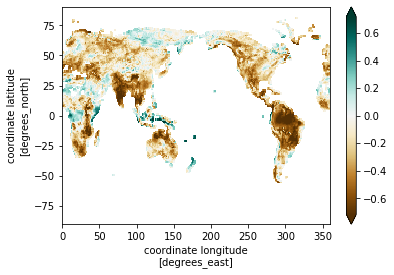

In [29]:
CLIM_DTann_corr = cor.pearson_correlation(dt_ann_anom['TWS'], dt_ann_anom['TBOT'], 'time')
FSDS_DTann_corr = cor.pearson_correlation(dt_ann_anom['TWS'], dt_ann_anom['FSDS'], 'time')
print('Annual detrended TBOT ~ TWS')
CLIM_DTann_corr.plot(robust=True, cmap='BrBG');

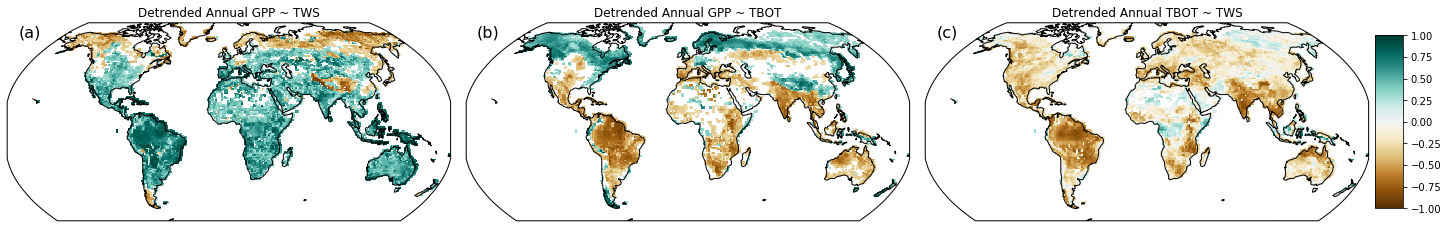

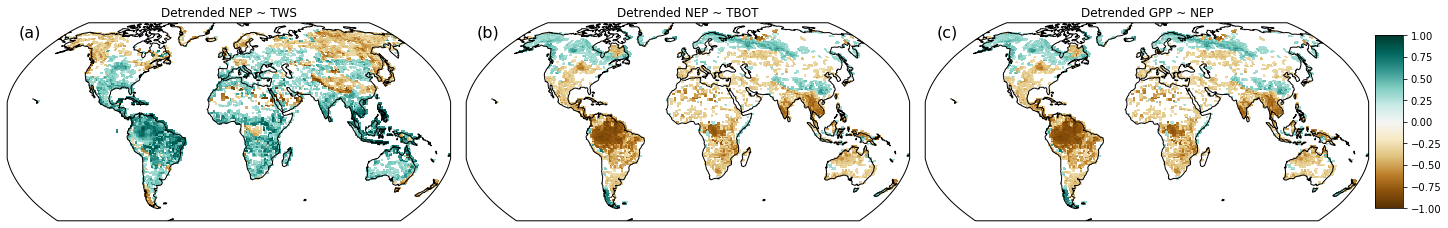

In [30]:
# create mask to only show statistically significant relationships
n = len(dt_ann_anom.time)
dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
r = 0.266
p = 2*dist.cdf(-abs(r))
p

# Now call the map_function
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

for index, ax in np.ndenumerate(axes):
    i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = GPP_DTann_corr[var[index[0]]]
    da_mask =  xr.ufuncs.fabs(da)
    da = da.where(da_mask>r) 
    if (i < 2):
        map_function(da, panel=panel[i], ax=ax, title='Detrended Annual GPP ~ '+var[index[0]], 
                  vmax=1, vmin=-1, cmap='BrBG',cb=0)

    else:
        map_function(CLIM_DTann_corr.where(da_mask>r), panel=panel[i], ax=ax, title='Detrended Annual TBOT ~ TWS', 
                     vmax=1, vmin=-1, cmap='BrBG',cb=1)
        

# or to provide a common color bar, set vmax/min so same values and 
#fig.colorbar(im,ax=axes.ravel().tolist(), shrink=0.5);
plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_3c_GPP_DTcorr.eps')

# NEP anomalies ~ climate & TWS ~ TBOT
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

for index, ax in np.ndenumerate(axes):
    i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    if (i < 2):
        da = NEP_DTann_corr[var[i]]
        da_mask =  xr.ufuncs.fabs(da)
        da = da.where(da_mask>r) 
        map_function(da, ax=ax, panel=panel[i], title='Detrended NEP ~ '+var[i], 
                      vmax=1, vmin=-1, cmap='BrBG',cb=0)
    else:
        map_function(da, ax=ax, panel=panel[i],title='Detrended GPP ~ '+var[index[0]], 
                     vmax=1, vmin=-1, cmap='BrBG',cb=1)
        
plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_3d_NEP_DTcorr.eps')

- Positive GPP ~ TBOT anomalies in high latitudes & GPP ~ TWS in mid & low lats 
- Strong correlations with C fluxes (GPP ~ NEP), less so with climate (TWS~TBOT)
### Make plots of SD of anomalies
- notably low variability in tropical forests, despite large fluxes

GPP mean of dt_ann_anom SD =  102.68288546608241
GPP mean of annual means =  949.7983965613942
TWS mean of dt_ann_anom SD =  56.356468889505805
TWS mean of annual means =  1959.3048533329932
TBOT mean of dt_ann_anom SD =  0.6747967310895169
TBOT mean of annual means =  285.30556657310836


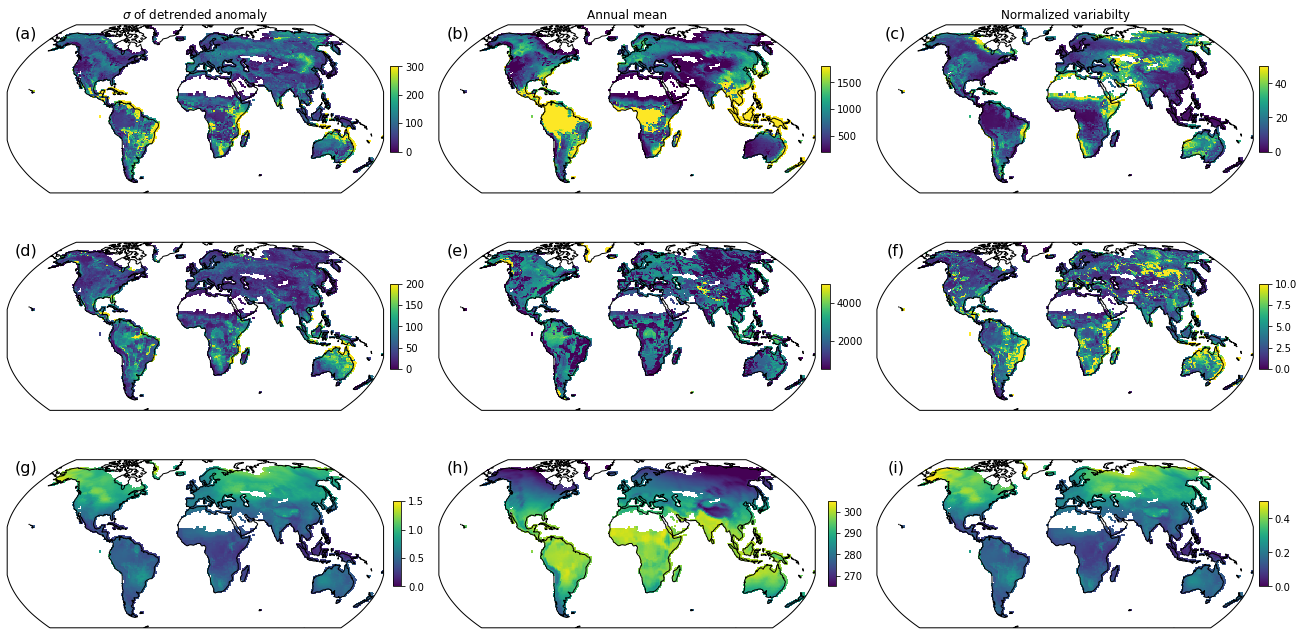

In [31]:
#plotVar = ['NEP','GPP','ER','TWS','TBOT']
plotVar = ['GPP','TWS','TBOT']
# customize colorbars with tuples of min and max values for each plot.
mins = [[0,  200,  0],[0   , 500,   0], [0, 265,   0]]
maxs = [[300,1800, 50],[200, 5000, 10], [1.5, 305, 0.5]]
TI = [[r'$\sigma$ of detrended anomaly' , 'Annual mean','Normalized variabilty'],[None,None,None],[None,None,None]]
fig, axes = plt.subplots(nrows=len(plotVar), ncols=3, figsize=(18,9), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

k = 0
for index, ax in np.ndenumerate(axes):
    j = index[0]
    i = index[1]
    da = dt_ann_anom[plotVar[j]].std(dim='time').where(ds_ann[plotVar[j]].max(dim='time')>0)
    if  (i == 0):
        print(plotVar[j]  + ' mean of dt_ann_anom SD =  '+  str(da.mean().values) )
    if (i == 1):
        da = ds_ann[plotVar[j]].mean(dim='time').where(ds_ann[plotVar[j]].max(dim='time')>0) 
        print(plotVar[j]  + ' mean of annual means =  '+  str(da.mean().values) )        
    if  (i == 2):
        da = da / ds_ann[plotVar[j]].mean(dim='time') * 100

    map_function(da, ax=ax, panel=panel[k], title=TI[j][i], vmin=mins[j][i], vmax=maxs[j][i],  cb=1)
    k  = k+1   
plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_S2_stddev_DTfluxAnom.eps');

TMF mean CV = 0.04
BCF mean CV = 0.06
MC mean CV = 0.04
CGP mean CV = 0.03


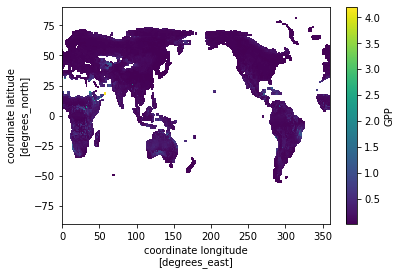

In [32]:
#Compare mean CV at grid cell for regions in Zach's paper (Table S3)
# This uses a much longer record than the satelite record in Zach's paper

# I'd calculate the CV as SD/mean
cvGPP = dt_ann_anom.GPP.std(dim='time').where(ds_ann.GPP.max(dim='time')>0) / ds_ann.GPP.mean(dim='time') * 100   

# Zach paper says "ratio of the interannual standard deviations to the seasonal amplitude of the multi-year mean"
# should I use the range of ds_clim in the denominator (units currently different)
ampl = (ds_clim.GPP.max(dim='time') - ds_clim.GPP.min(dim='time') )*s2y
cvGPP = dt_ann_anom.GPP.std(dim='time').where(ds_ann.GPP.max(dim='time')>0) / ampl
cvGPP = cvGPP.where(cvGPP.max()>0)

region = ['TMF','BCF','MC','CGP']
a = [43,54,39,50]
b = [48,59,44,55] 
d = [360-84, 360-94, 360-96,360-105]
c = [360-94,360-104,360-106,360-115]

for i in range(4):
    regMean = cvGPP.sel(lat=slice(a[i],b[i]), lon=slice(c[i],d[i])).mean().values
    print(region[i] + " mean CV = " + str(np.round_(regMean,2)) )
    
cvGPP.plot();

--------------
# Play around with SVD now
* Calculate climatology & seasonal anomalies [ trend already removed ], then
* Reshape for SVD & finally
* Identify amplification vs. early onset vectors
* Determine how SV weights correspond with GPP anomalies (+ or -)

#### Define wrapper function that includes: 
- Detrending, reshaping, SVD & 
- Returns a np.array with vectors, weights, theta & varfrac
- We dont' need the SV for TBOT and TWS, but we do need seasonal means of detrended anomalies 

In [33]:
# define function to cacluate svd vectors, weights, etc.
# First we have to detrend the data
def svd_wrap(anom, years=years):
    theta = np.full(years, np.nan)
    varfrac = np.full(years, np.nan)
    if np.isnan(anom)[0] == False:
        #detrend results, if needed
        detrend = signal.detrend(anom)  
    
        #reshape timeseries vector into a matrix (months x year) 
        matrix=np.zeros([12, years])
        for iyr in range(years):
            matrix[0:12, iyr]=detrend[iyr*12:(iyr+1)*12] 
    
        #Call the function to calculate the singular vectors and their annual weights
        [vectors, weights]=svd.decompose(matrix) 
        [theta,varfrac]=svd.calc_redistribution(vectors, weights, matrix)

    return theta, varfrac, vectors, weights

#### Make frunction to Loop through each grid cell & dataset to save output
- Would Dask make this faster?
- how do we also mask non-veg land cells?


In [34]:
# TODO, this is the time consuming bit of the code.
# JH recommends using map_blocks, once it's developed farther
def calc_svd(da, nyears=years):
    dims = dict(zip(da.dims, da.shape))
    yx_shape = (dims['lat'], dims['lon'])
    # setup output variables
    # number of vectors in svd = nyears
    theta_shape = yx_shape + (nyears, )
    vector_shape = yx_shape + (nyears, 12)
    weights_shape = yx_shape + (nyears, nyears)
    out = xr.Dataset( coords={"lat": da.lat, "lon": da.lon, 'sv': range(nyears) } )

    varnames = ['theta', 'varfrac', 'vectors', 'weights']
    out['theta'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'sv'))
    out['varfrac'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'sv'))
    out['vectors'] = xr.DataArray(np.zeros(vector_shape), dims=('lat', 'lon', 'sv', 'time'))
    out['weights'] = xr.DataArray(np.zeros(weights_shape), dims=('lat', 'lon', 'sv', 'year'))
    # For clarity, rename dimensions of weights (dim1 = vector#, dim2 = year)
    #                                   vectors (dim1 = vector#, dim2 = month)
    for (i, j), mask in np.ndenumerate(da.isel(time=0).isnull()):
        if not mask:
            return_vals = svd_wrap(da.isel(lat=i, lon=j).data)

            for varname, vals in zip(varnames, return_vals):
                out[varname][i, j, ...] = vals

    return out

In [35]:
%%time
gpp = ds_anom.get('GPP').transpose('time','lat','lon') 
svdGPP = calc_svd(gpp)   
print('-------------------')

-------------------
CPU times: user 6min 49s, sys: 2.06 s, total: 6min 51s
Wall time: 6min 50s


###  finished svdGPP 
-----------------

In [36]:
# rearrange output
def transpose(da_in, var):
    out = da_in
    out['theta']   = out.theta.transpose('sv','lat','lon')
    out['varfrac'] = out.varfrac.transpose('sv','lat','lon')
    out['vectors'] = out.vectors.transpose('sv', 'time','lat','lon') 
    out['weights'] = out.weights.transpose('sv', 'year','lat','lon')
    ds_clim['time'] = out.time  # get time coords to match
    out['climatology'] = ds_clim.get(var)
    #out.to_netcdf(path='/glade/scratch/wwieder/svd/'+model+'_svd_'+var+'.nc')  
    return out

svdGPP = transpose(svdGPP, 'GPP') 
print(svdGPP)

<xarray.Dataset>
Dimensions:      (lat: 192, lon: 288, sv: 55, time: 12, year: 55)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * lat          (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon          (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * sv           (sv) int64 0 1 2 3 4 5 6 7 8 9 ... 46 47 48 49 50 51 52 53 54
Dimensions without coordinates: year
Data variables:
    theta        (sv, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    varfrac      (sv, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    vectors      (sv, time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    weights      (sv, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    climatology  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan


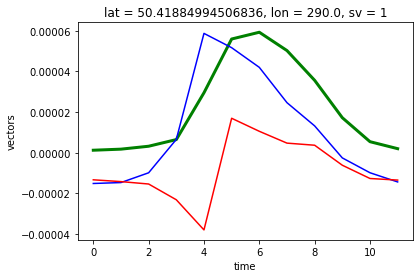

In [37]:
# quick look at results,  climatology, SV1, & SV2
tlat = 50  #60, 70 #-5  #46  #-3
tlon = 290 #240,30 #300 #262 #280
svdGPP.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='g',lw=3)
svdGPP.vectors.isel(sv=0).sel(lat=tlat, lon=tlon, method='nearest').plot(color='b')
svdGPP.vectors.isel(sv=1).sel(lat=tlat, lon=tlon, method='nearest').plot(color='r');

### Make plots to visualize results

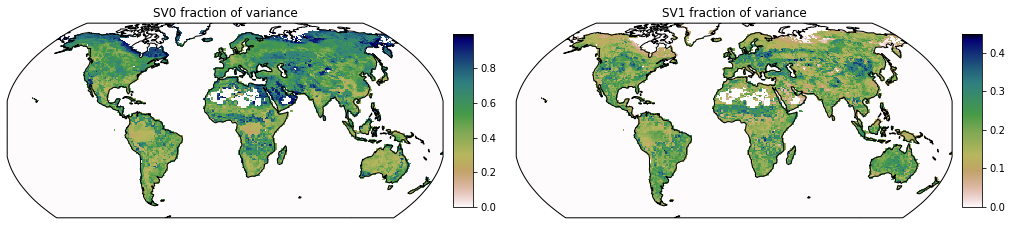

In [38]:
# Now call the map_function
# This will be repeated after identifying SV0 and SV1 as amplification or redistribution vectors.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = svdGPP.varfrac.isel(sv=index[0])
    map_function(da, ax=ax, title='SV'+str(index[0])+' fraction of variance', 
                  vmax=da.max(), vmin=da.min(), cmap='gist_earth_r',cb=1)

### Identify amplificaiton vs. redistribution vectors from correlations w/ GPP 

- This will be used to identify SV1 vs. SV2 as amplificaiton vector
- Vectors from SV with highest absolute correlation coefficient = amplification

In [39]:
import corrFunc as cor
#import importlib
#import sys
#importlib.reload(sys.modules['corrFunc'])
#from corrFunc import corrFunc as cor

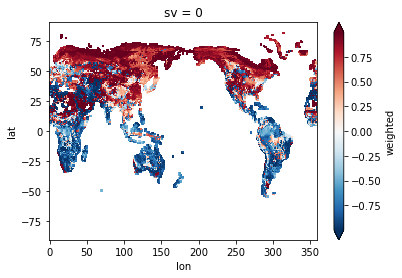

In [40]:
# Pull off climatology of GPP & calculate weights based on annual cycle
GPPwgt  = svdGPP.climatology / svdGPP.climatology.sum(dim='time') 
# setup output variables
dims = dict(zip(ds[var[0]].dims, ds[var[0]].shape))
yx_shape = (dims['lat'], dims['lon'])
corr_shape = (years, ) + yx_shape  # number of vectors in svd = nyears
    
GPP_corr = xr.Dataset( coords={'sv': range(years) , "lat": ds.lat, "lon": ds.lon} )
GPP_corr['pearson'] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))
GPP_corr['weighted'] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))
GPP_corr['ranked'] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))

# now calculate correlations
for i in range(2):  #just do this for first two vectors
    temp_vector = svdGPP.vectors.isel(sv=i)
    GPP_corr.pearson[i,...] = cor.pearson_correlation(svdGPP.climatology, temp_vector, 'time')
    GPP_corr.weighted[i,...] = cor.pearson_correlation_wgt(svdGPP.climatology, temp_vector, GPPwgt,'time')
    GPP_corr.ranked[i,...] = cor.spearman_correlation(svdGPP.climatology, temp_vector, 'time')

GPP_corr.weighted[0,:,:].plot(robust=True);

negative correlations suggest that some vectors will have to be flipped to match climatology

In [41]:
# Mask values to isolate regions with amplificaiton vs. redistribution
# here using weighted correlation, but also could use ranked 
SVtype = ['amplification','redistribution']
mask_shape = (2, ) + yx_shape
sv_mask = xr.Dataset( coords={'sv_type': SVtype , "lat": ds.lat, "lon": ds.lon} )
corType = ['weighted', 'ranked','pearson']

for i in range(len(corType)):
    sv_mask[corType[i]] = xr.DataArray(np.zeros(mask_shape), dims=('sv_type','lat', 'lon'))
    sv_mask[corType[i]][0,...] = xr.ufuncs.fabs(GPP_corr[corType[i]][0,...]) >= \
                               xr.ufuncs.fabs(GPP_corr[corType[i]][1,...])  
    sv_mask[corType[i]][1,...] = xr.ufuncs.fabs(GPP_corr[corType[i]][1,...]) > \
                               xr.ufuncs.fabs(GPP_corr[corType[i]][0,...])  

print(sv_mask['weighted'].sel(lat=tlat, lon=tlon, method='nearest') )

<xarray.DataArray 'weighted' (sv_type: 2)>
array([1., 0.])
Coordinates:
    lat      float64 50.42
    lon      float64 290.0
  * sv_type  (sv_type) object 'amplification' 'redistribution'


#### Make plots of grids that are dominated by amplification or redistribution vectors

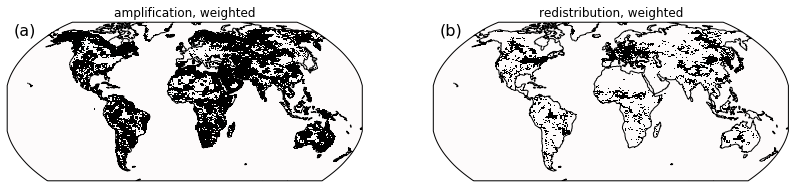

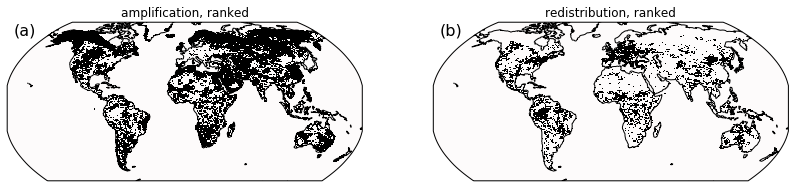

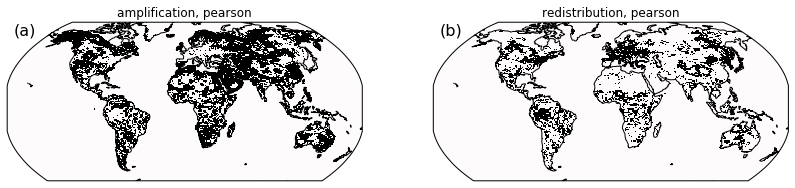

In [42]:
for i in range(len(corType)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), constrained_layout=False,
                             subplot_kw=dict(projection=ccrs.Robinson()))
    for index, ax in np.ndenumerate(axes):
        j  = index[0]
        da = sv_mask[corType[i]].isel(sv_type=index[0])
        map_function(da, panel=panel[j], ax=ax, 
                     title=str(sv_mask.sv_type[index[0]].values)+', '+corType[i], 
                     cmap='gist_earth_r')
        if (i ==2):
            plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_S3_GPP_'+corType[i]+'Vectors.eps')

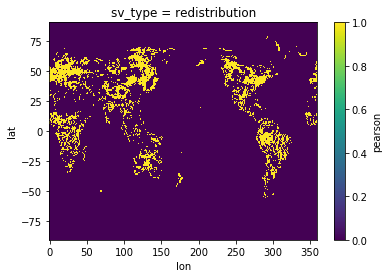

In [43]:
corType = 'pearson'   # Use pearson correlations here
sv_mask[corType].isel(sv_type=1).plot(robust=True);
# Make a new  dataset to hold results 
svdGPP2 = svdGPP.copy(deep=True)

In [44]:
# for amplification, select Vector0 when SVtype = 0, else select Vector1
# for redistribution, selct Vector0 when SVtype = 1, else select Vector 1

# Check that logic  is working
## Selects amplification for sv=0
#temp = svdGPP['varfrac'].isel(sv=0).where(sv_mask[corType].isel(sv_type=0)==1,
#                                          svdGPP['varfrac'].isel(sv=1))
## Selects redistribution for sv=1
#temp = svdGPP['varfrac'].isel(sv=0).where(sv_mask[corType].isel(sv_type=1)==1,
#                                          svdGPP['varfrac'].isel(sv=1))
# print(temp.mean())
# temp.plot(robust=True)

# now save the  output
varnames = ['theta', 'varfrac', 'vectors', 'weights']
for i in range(len(varnames)):
    for j in range(2):
        svdGPP2[varnames[i]][j,...] = svdGPP[varnames[i]].isel(sv=0).where(
            sv_mask[corType].isel(sv_type=j)==1,svdGPP[varnames[i]].isel(sv=1)).values


<xarray.Dataset>
Dimensions:      (lat: 192, lon: 288, sv: 2, time: 12, year: 55)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * lat          (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon          (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * sv           (sv) <U14 'amplification' 'redistribution'
Dimensions without coordinates: year
Data variables:
    theta        (sv, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    varfrac      (sv, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    vectors      (sv, time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    weights      (sv, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    climatology  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan


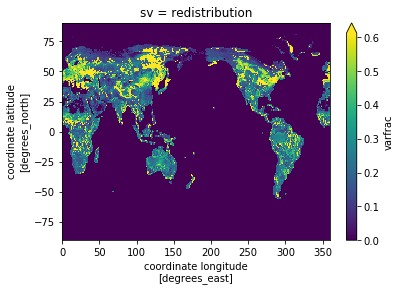

In [45]:
# just carry around first two vectors, rename 
svdGPP2 = svdGPP2.isel(sv=slice(0,2)).where(ds.GPP.max())
svdGPP2.coords['sv'] = SVtype
svdGPP2.varfrac.isel(sv=1).plot(robust=True);
print(svdGPP2)

#### Phase shift mainly in agricutrulal regions & temperate decid. forest
### Use seasonal correlations to determine where to flip SVD vector and weights

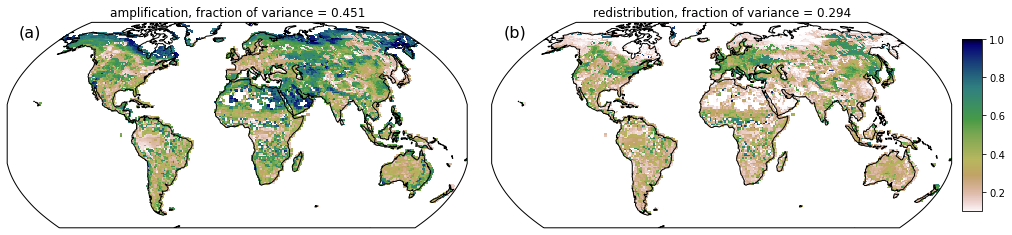

In [46]:
# Now call the map_function to save varfrac for each vector
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

# varfrac weighted by grid cell area
for index, ax in np.ndenumerate(axes):
    i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = svdGPP2.varfrac.isel(sv=index[0])
    da = da.where(da>0)
    da_weight = da * land_wgt
    da_weight = np.round_(da_weight.sum(),3).values
    da_mean = np.round_(da.mean(),2).values
    map_function(da, ax=ax, panel=panel[i],
                 title= str(svdGPP2.coords['sv'][index[0]].values)+', fraction of variance = '+str(da_weight), 
                 vmax=1, vmin=0.1, cmap='gist_earth_r',cb=index[0])

#plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_4_GPP_sv_Variance.eps')

In [47]:
# Together amplifacation and redistribution vectors describe a large amount of GPP variabiality
temp = svdGPP2.varfrac * land_wgt 
temp = temp.sum()
print('mean SV 1-2 varfrac = ' + str(np.round_(temp,3).values))

mean SV 1-2 varfrac = 0.746


## ----- Correlate SV weights w/ seasonal anomalies -----
* Calculate seasonal means of detrended data
* Reshape anomaly vectors to season x year array
* Correlate GPP SV1 weights w/ seasonal GPP anomalies & 
* Reverse / flip weights where needed
* Calculate correlation for GPP SV1 weights w/ seaonal climate anomalies

In [48]:
# Build datastet to hold seasonal results
dims = dict(zip(ds_anom.get(var[0]).dims, ds_anom.get(var[0]).shape))
out_shape = (dims['lat'], dims['lon'], 4, years)
seasonID = xr.DataArray([12,3,6,9], dims='season') # seasonal time slices
seasonName = xr.DataArray(['DJF','MAM','JJA','SON'], dims='season') # can coords be a string?
yearID   = xr.DataArray(np.unique(ds_anom.time['time.year']), dims='year')
dt_anom  = xr.Dataset( coords={"lat": ds_anom.lat, "lon": ds_anom.lon, 
                               "season": seasonName, "year": yearID} )
# set up another dataset for raw data that gets detrended
dt_raw   = xr.Dataset( coords={"lat": ds_anom.lat, "lon": ds_anom.lon, 
                               "season": seasonName, "year": yearID} )

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, season: 4, year: 55)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * year     (year) int64 1960 1961 1962 1963 1964 ... 2010 2011 2012 2013 2014
Data variables:
    TWS      (season, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TBOT     (season, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    NEP      (season, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    GPP      (season, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ER       (season, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    FSDS     (season, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SFCO2    (season, year, lat, lon) float64 0.0 0.0 ... -6.403e-11 -6.405e-11


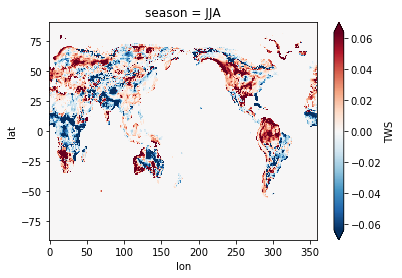

In [49]:
# loop over variables
for v in range(len(var)):
    dt_anom[var[v]] = xr.DataArray(np.zeros(out_shape), dims=('lat', 'lon','season','year'))
    dt_raw[var[v]]  = xr.DataArray(np.zeros(out_shape), dims=('lat', 'lon','season','year'))
    
    # Detrend data at each grid cell
    dt   = dtrend(ds_anom.get(var[v]).load().fillna(0), 'time')
    dt_r = dtrend(ds.get(var[v]).load().fillna(0), 'time')

    # Caculate seasonal means from detrended data
    dt_season = dt.resample(time="QS-DEC").mean().isel(time=slice(0,-1))
    dt_season_raw = dt_r.resample(time="QS-DEC").mean().isel(time=slice(0,-1))

    # now reshape to season * year
    for m in range(len(seasonID)):
        temp = dt_season.where(dt_season.time['time.month']==seasonID[m], drop=True)
        temp_raw = dt_season_raw.where(dt_season_raw.time['time.month']==seasonID[m], drop=True)

        dt_anom[var[v]][:,:,m,:] = temp
        dt_raw[var[v]][:,:,m,:] = temp_raw
        
dt_anom = dt_anom.transpose('season','year','lat','lon')
dt_raw  = dt_raw.transpose( 'season','year','lat','lon')
dt_anom.TWS.isel(season=2).mean(dim='year').plot(robust=True);
dt_SD = dt_raw.std(dim='year') # calculates SD of detrended data across seasons for each year  
dt_anomSD = dt_anom.std(dim='year') # calculates SD of detrended anomalies across seasons for each year  
print(dt_anom)

In [50]:
#import corrFunc as cor
# Correlation of SVD weights (nyears) with detrended seasonal anomalies (nyears)
# Function loops over each variable (4), SV (2), & season (4)
def corr_wrap(anom, svd):
    da = anom.to_array() 
    dims = dict(zip(da.dims, da.shape))
    corr_shape = (2,dims['season'], dims['lat'], dims['lon'])

    # setup output variables
    corr = xr.Dataset( coords={'sv': SVtype, 'season':seasonName, 
                               "lat": ds.lat, "lon": ds.lon} )

    sig = xr.Dataset( coords={'sv': SVtype, 'season':seasonName, 
                               "lat": ds.lat, "lon": ds.lon} )

    for v in range(len(var)):     # variables
        corr[var[v]] = xr.DataArray(np.zeros(corr_shape), dims=('sv','season','lat', 'lon'))

        # loop through to calculate correlation coef.
        for i in range(2):         # vectors
            for j in range(len(seasonName)): # seasons
                x = anom.get(var[v]).isel(season=j)
                y = svd['weights'].isel(sv=i)
                return_vals = cor.pearson_correlation(x, y, 'year')
                corr[var[v]][i,j,...] = return_vals
        
    return corr  

In [51]:
from scipy import stats
def pearson_correlation(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    r_value, p_value = stats.pearsonr(x,y)
    return np.array([r_value, p_value])

pCOR = xr.apply_ufunc(pearson_correlation, dt_anom['GPP'], dt_anom['TBOT'],
                        input_core_dims=[['year'], ['year']],
                        output_core_dims=[["parameter"]],
                        vectorize=True,
                        dask="parallelized",
                        output_dtypes=['float64'],
                        output_sizes={"parameter": 2},
                        )
                        
print('finished  pCOR')
    
def new_linregress(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

# return a new DataArray
reg_stats = xr.apply_ufunc(new_linregress, dt_anom['GPP'], dt_anom['TBOT'],
                        input_core_dims=[['year'], ['year']],
                        output_core_dims=[["parameter"]],
                        vectorize=True,
                        dask="parallelized",
                        output_dtypes=['float64'],
                        output_sizes={"parameter": 5},
                        )

print('finished  stats')



finished  pCOR
finished  stats


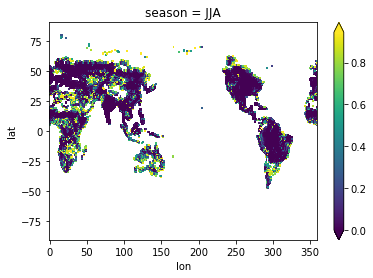

In [52]:
pCOR.isel(season=2,parameter=1).where(pCOR.isel(season=2,parameter=0)<0.05).plot(robust=True);

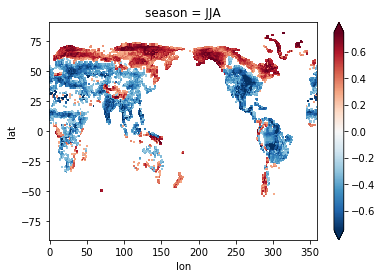

In [53]:
reg_stats.isel(season=2,parameter=2).where(reg_stats.isel(season=2,parameter=3)<0.05).plot(robust=True);

In [54]:
# Create correlation matrix of detrended anomalies with SVD weights
# first make year dimensions indential
svdGPP2['year'] = dt_anom.get('year')
svdGPP_corr = corr_wrap(dt_anom, svdGPP2) #correlation 
print(svdGPP_corr)

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, season: 4, sv: 2)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * sv       (sv) object 'amplification' 'redistribution'
Data variables:
    TWS      (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    TBOT     (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    NEP      (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    GPP      (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ER       (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    FSDS     (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    SFCO2    (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan


### Identify season with highest correlation to SVD weights

In [55]:
# xr.ufuncs.fabs calculates the absolute value for an xarray object
# argmax picks the index of the largest value across a dimension.
gppMask = svdGPP_corr.GPP.max(dim='season') # mask out oceans
maxGPP_season = xr.ufuncs.fabs(svdGPP_corr.GPP.fillna(-1)).argmax(dim='season').where(gppMask.notnull())
#print(ds.GPP.resample(time="QS-DEC"))
#ds_climo.GPP.isel(season=0, year=0).plot(robust=True)
#simple = maxGPP_season.plot(x='lon', y='lat', col='sv', col_wrap=2);

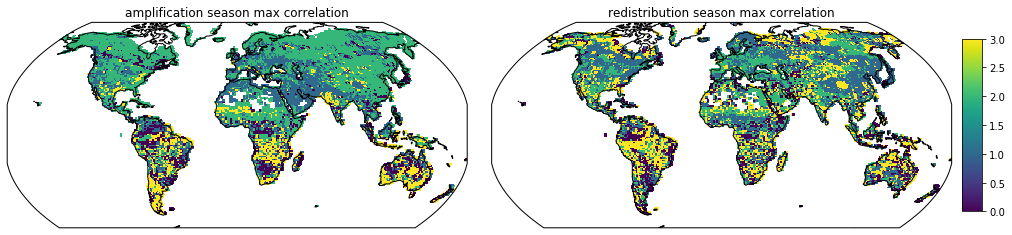

In [56]:
# Now call the map_function to save varfrac for each vector
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = maxGPP_season.isel(sv=index[0])
    map_function(da, ax=ax, 
                 title= str(maxGPP_season.coords['sv'][index[0]].values)+' season max correlation', 
                 cb=index[0])

#plt.savefig('/glade/scratch/wwieder/svd/'+model+'_Fig_3_GPP_sv_Variance.eps')

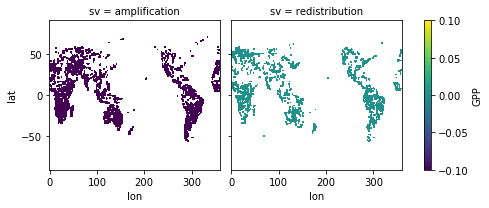

In [57]:
#use same logic to identify points with negative correlation between GPP anomalies and SVD weights 
#print(svdGPP_corr.GPP)
#print(svdGPP_corr.GPP.sel(lat=50,lon=290,method='nearest'))
flipMask = svdGPP_corr.GPP.min(dim='season').where(gppMask.notnull()) 
maxGPP_abs = xr.ufuncs.fabs(svdGPP_corr.GPP).max(dim='season').where(gppMask.notnull())
flipMask = flipMask + maxGPP_abs
flipMask = flipMask.where(flipMask==0, np.nan)
#flipMask.isel(sv=0).plot()
maxGPP_flip = xr.ufuncs.fabs(svdGPP_corr.GPP.fillna(-1)).argmax(dim='season').where(flipMask.notnull())
##simple = maxGPP_flip.plot(x='lon', y='lat', col='sv', col_wrap=2);
#print(flipMask.sel(lat=tlat, lon=tlon, method='nearest'))

# Only flip the vectors and weights associated with amplification vectors
maxGPP_flip[0,:,:] = flipMask[0,:,:].where(sv_mask[corType].isel(sv_type=0)==1,np.nan)
maxGPP_flip[1,:,:] = flipMask[1,:,:].where(sv_mask[corType].isel(sv_type=1)==1,np.nan)
simple = maxGPP_flip.plot(x='lon', y='lat', col='sv', col_wrap=2);
#maxGPP_flip = maxGPP_flip.where(maxGPP_flip<=0, 1)
#print(maxGPP_flip.sel(lat=tlat, lon=tlon, method='nearest'))

### Flip amplification vectors when correlations w/ seasonal anomalies are negative

In [58]:
## create new datasets that don't change the orig. results
svd2 = svdGPP2.copy(deep=True) 

# just flip amplification 
for i in range(1):
    svd2.vectors[i,...] = svd2.vectors[i,...].where(maxGPP_flip[i,...].notnull()==False, -1*svd2.vectors[i,...])
    svd2.weights[i,...] = svd2.weights[i,...].where(maxGPP_flip[i,...].notnull()==False, -1*svd2.weights[i,...])
    svd2.theta[i,...] = svd2.theta[i,...].where(maxGPP_flip[i,...].notnull()==False, -1*svd2.theta[i,...])

### Reindex over time for sv vectors & climatology for SH to match hydrologic year

In [59]:
idx = [6,7,8,9,10,11,0,1,2,3,4,5]
svdSH = svd2.copy(deep=True)
svdSH = svdSH.reindex(time=idx)
svdSH['time'] = svd2.time
svd2 = svdSH.where(svdSH.lat<0, svd2)
tlat = -5
tlon = 300
x = svdSH.climatology.sel(lat=tlat, lon=tlon, method='nearest')
y1 = svdSH.vectors.isel(sv=0).sel(lat=tlat, lon=tlon, method='nearest')
y2 = svdSH.vectors.isel(sv=1).sel(lat=tlat, lon=tlon, method='nearest')
#plt.plot(x, y1, 'b*')
#plt.plot(x, y2, 'r*');
#svdGPP.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='g',lw=3)
#svdGPP2.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='k',lw=3);
#svd2.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='b',lw=3);

#svd2['climatology'].values = svd2.climatology.where(svd2.lat>=0, svdSH.climatology.values)
#svd2['vectors'].values = svd2.vectors.where(svd2.lat>=0, svdSH.vectors.values)

### Flip redistribution SV when month of min vector come before max vector

<xarray.DataArray 'vectors' (sv: 2)>
array([1, 0])
Coordinates:
    lat      float64 -5.183
    lon      float64 300.0
  * sv       (sv) <U14 'amplification' 'redistribution'
<xarray.DataArray 'pearson' (sv_type: 2)>
array([0., 1.])
Coordinates:
    lat      float64 -5.183
    lon      float64 300.0
  * sv_type  (sv_type) object 'amplification' 'redistribution'


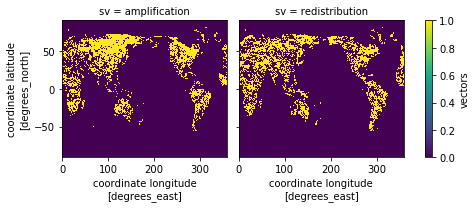

In [60]:
# Still need a better way to think about flipping early phase vectors where needed...
# currently selects when minimum month comes before max & reverses early shift SV
max_vector = svd2.vectors.argmax(dim='time') 
min_vector = svd2.vectors.argmin(dim='time') 
flip_vector = 0+(min_vector < max_vector)
#flip_vector[0,:,:] = flip_vector[0,:,:].where(sv_mask[corType].isel(sv_type=1)==1,0)#.where(sv_mask[corType].isel(sv_type=1),0)
#flip_vector[1,:,:] = flip_vector[1,:,:].where(sv_mask[corType].isel(sv_type=1)==0,0)
simple = flip_vector.plot(x='lon', y='lat', col='sv', col_wrap=2);

print(flip_vector.sel(lat=tlat, lon=tlon, method='nearest'))
print(sv_mask[corType].sel(lat=tlat, lon=tlon, method='nearest') )
#sv_mask[corType].isel(sv_type=0).plot()

#for i in range(years):
# just flip redistribution
svd2.vectors[1,...] = svd2.vectors[1,...].where(flip_vector[1,...] <= 0, -1*svd2.vectors[1,...])
svd2.weights[1,...] = svd2.weights[1,...].where(flip_vector[1,...] <= 0, -1*svd2.weights[1,...])
svd2.theta[1,...] = svd2.theta[1,...].where(flip_vector[1,...] <= 0, -1*svd2.theta[1,...])


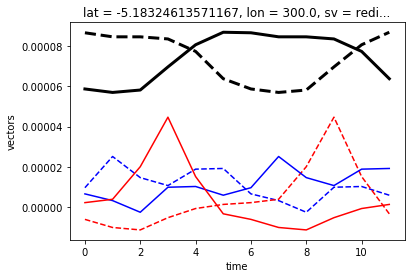

In [61]:
# quick look at results
tlat = -5  #60, 70 #-5  #46  #-3
tlon = 300 #240,30 #300 #262 #280
svdGPP.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='k',lw=3,ls='--')
svd2.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='k',lw=3)
svdGPP2.vectors.isel(sv=0).sel(lat=tlat, lon=tlon, method='nearest').plot(color='b',ls='--')
svdGPP2.vectors.isel(sv=1).sel(lat=tlat, lon=tlon, method='nearest').plot(color='r',ls='--')
svd2.vectors.isel(sv=0).sel(lat=tlat, lon=tlon, method='nearest').plot(color='b')
svd2.vectors.isel(sv=1).sel(lat=tlat, lon=tlon, method='nearest').plot(color='r');

In [62]:
def plotQuick(tlat, tlon):
    col = ['b','r']
    labels=("Climatology", SVtype[0], SVtype[1] )
    legend =("Amp GPP anomalies", "Phase ~ MAM GPP anomalies", 'Phase ~ JJA anomalies')

    plt.figure(figsize=[15,4])

    plt.subplot(131)
    svdGPP.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='g',lw=3)
    for i in range(2):
        svdGPP2.vectors.isel(sv=i).sel(lat=tlat, lon=tlon, method='nearest').plot(color=col[i])
    plt.legend(labels=labels);
    plt.title('SVD tlat='+str(tlat)+' tlon='+str(tlon))
    plt.ticklabel_format(axis='y', style='', scilimits=(-2,2))

    plt.subplot(132)
    svd2.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='g',lw=3)
    for i in range(2):
        svd2.vectors.isel(sv=i).sel(lat=tlat, lon=tlon, method='nearest').plot(color=col[i])
    plt.title('reshaped SVD vectors')
    plt.ticklabel_format(axis='y', style='', scilimits=(-2,2))

    plt.subplot(133)
    if tlat>=0:
        season = [2,1] #first vector = amplification
        for i in range(2):
            plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=season[i]),
                     svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=i), '*', color=col[i])

        plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=2),
                 svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=1), '*', color='k')

        plt.legend(labels=legend)
    else:
        plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=3),
                 svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0), '*', color='red')
        plt.plot(dt_anom.GPP.sel(lat=tlat, lon=tlon, method='nearest').isel(season=1),
                 svd2.weights.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=1), '*', color='blue')
        plt.legend(labels=("SV1 ~ SON GPP anomalies","SV2 ~ MAM GPP anomalies"))
    
    plt.ticklabel_format(axis='x', style='', scilimits=(-2,2))
    plt.title('SVD weights ~ GPP anomalies');
    plt.xlabel('GPP seasonal anomalies (gC/m2/s)')
    plt.ylabel('GPP SV weights');
    #print(svd2.sel(lat=tlat, lon=tlon, method='nearest').isel(sv=0))

    plt.subplots_adjust(wspace=0.25);

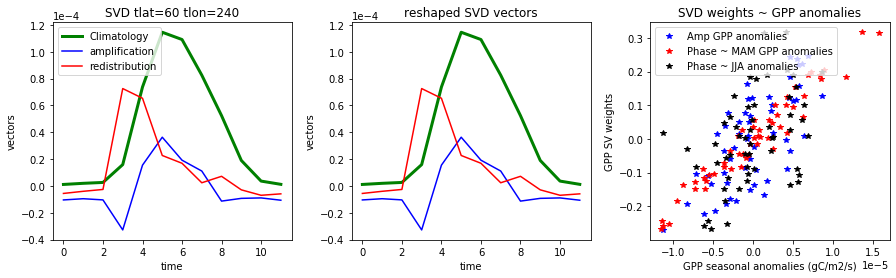

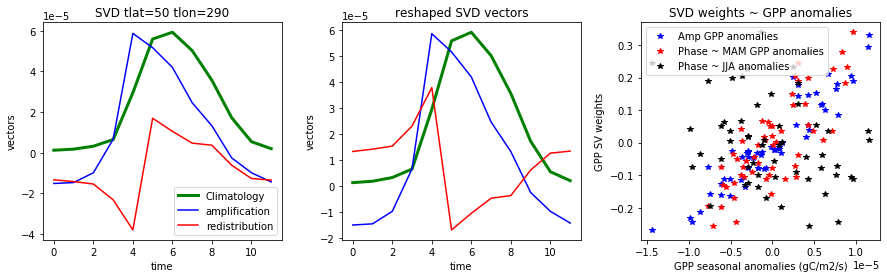

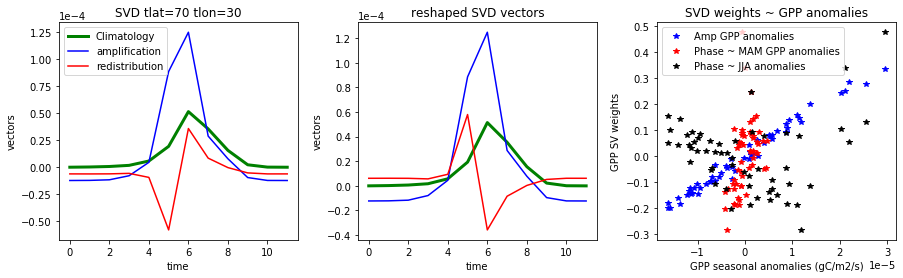

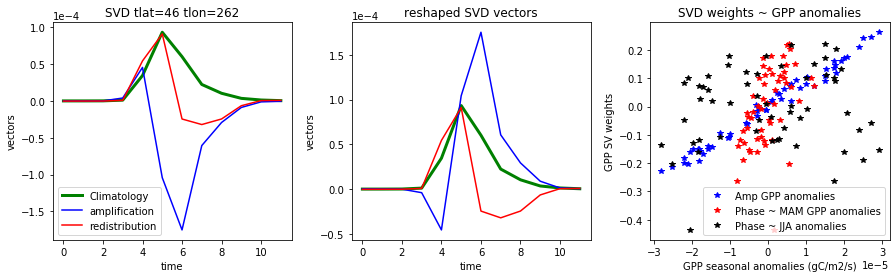

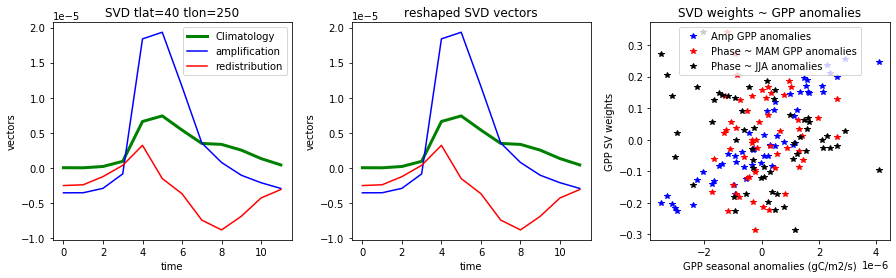

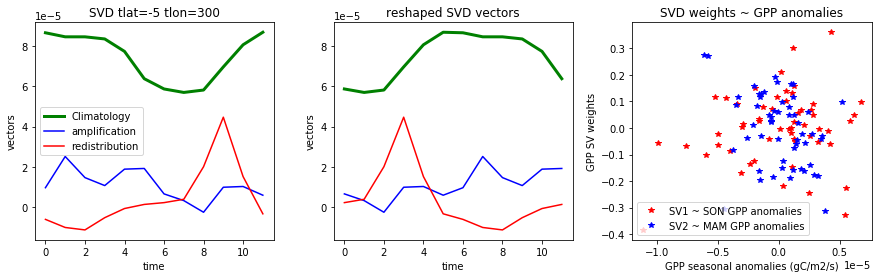

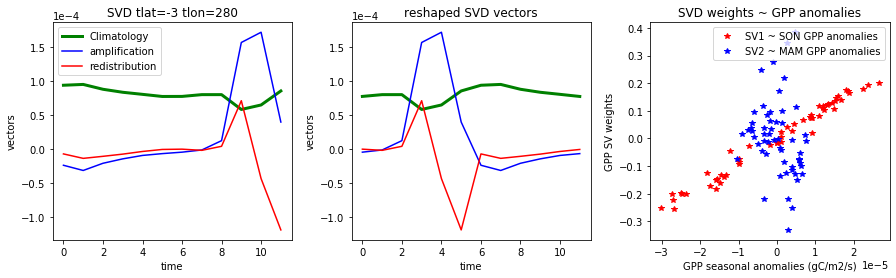

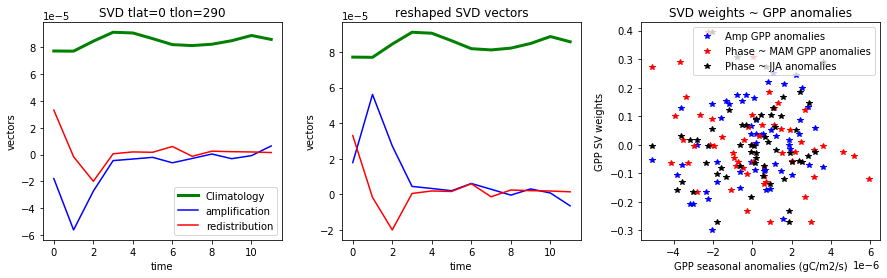

In [63]:
# quick look at results
tlat = [60 ,  50, 70,  46,  40, -5 ,  -3, 0]
tlon = [240, 290, 30, 262, 250, 300, 280, 290]
for i in range(len(tlat)):
    plotQuick(tlat = tlat[i] ,tlon = tlon[i])

### Weights of SV1 well correlated seasonal GPP anomalies 
#### Repeat correlation between monthly climatology and SV vectors

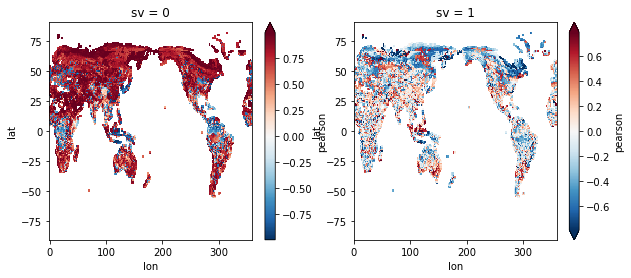

In [64]:
for i in range(2):
    temp_vector = svd2.vectors.isel(sv=i)
    GPP_corr.pearson[i,...] = cor.pearson_correlation(svd2.climatology, temp_vector, 'time')
    GPP_corr.weighted[i,...] = cor.pearson_correlation_wgt(svd2.climatology, temp_vector, GPPwgt,'time')
    GPP_corr.ranked[i,...] = cor.spearman_correlation(svd2.climatology, temp_vector, 'time')

plt.figure(figsize=[10,4])
for i in range(2):
    plt.subplot(1,2,(i+1))
    GPP_corr[corType][i,:,:].plot(robust=True);

#### Amplification vectors now well correlated with climatology of GPP in NH and SH

In [65]:
# Plot First and Second Singular Vectors
# Made this long plotting routine into a function

#def monthly_plots(ds_all, ds0, ds1, a, b, nA,nB,multi = 0.5e4, save=True ):
#def monthly_plots(ds_all, ds0, a, b, multi = 0.5e4, save=True ):
def monthly_plots(ds0, ds1, a0, b0, a1, b1, panel,multi = 0.5e4, save=True ):
    
    fig = plt.figure(4,figsize=(6,4.5))
    barwidth = 0.2
    month = np.arange(12)
    multi = multi       #This is a totally arbitrary scale factor, decided by me, to make figures look good!
    ymax=np.max(ds0.vectors.values)

    # --- GPP, SVD 1 & 2 for regions in phase with GPP 
    vectors2plot=ds0.vectors*multi  
    mm2plot = ds0.climatology
    ax1 = fig.add_subplot(1,2,1)

    if b0 > 0:
        ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
    else:
        ax1.set_xticklabels(['Jul','','','Oct','','','Jan','','','Apr','',''])

    ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'darkgray',linewidth=3)
    ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'darkgray',linewidth=3)

    ax1.plot(np.array(month)+2*barwidth,vectors2plot[0,:]*0.75+0.35,'tab:blue',linewidth=3)
    ax1.plot(np.array(month)+2*barwidth,vectors2plot[1,:]*0.75-0.05,'tab:red',linewidth=3)
    ax1.axhline(-0.05,color='black')
    ax1.axhline(0.35,color='black')
    ax1.set_xticks(np.array(month)+2*barwidth)
    ax1.set_yticks([-0.05,0.35])
    ax1.set_yticklabels(['Redist','Amp'])
    ax1.set_ylim([-0.2,0.65])

    ax1.text(0.5,0.26,str(int(ds0.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%ds0.theta[0]))
    ax1.text(0.5,-0.14,str(int(ds0.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%ds0.theta[1]))
    ax1.text(0.10, 0.92,panel[0], fontsize=14,
            ha='center', va='center', transform=plt.gca().transAxes)

    #ax1.text(0.5,.52,str(int(ds0.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%ds0.theta[0]))
    #ax1.text(0.5,.15,str(int(ds0.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%ds0.theta[1]))
    ax1.title.set_text('GPP '+str(a0)+"-"+str(b0)+"")
    #ax1.text(4,-0.29,'Month')

    # ----- Make second panel ----
    vectors2plot=ds1.vectors*multi  
    mm2plot = ds1.climatology
    ax2 = fig.add_subplot(1,2,2)

    if b1 > 0:
        ax2.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
    else:
        ax2.set_xticklabels(['Jul','','','Oct','','','Jan','','','Apr','',''])

    ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'darkgray',linewidth=3)#,alpha=0.3)
    ax2.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'darkgray',linewidth=3)#,alpha=0.3)

    ax2.plot(np.array(month)+2*barwidth,vectors2plot[0,:]*0.75+0.35,'tab:blue',linewidth=3)
    ax2.plot(np.array(month)+2*barwidth,vectors2plot[1,:]*0.75-0.05,'tab:red',linewidth=3)
    ax2.axhline(-0.05,color='black')
    ax2.axhline(0.35,color='black')
    ax2.set_xticks(np.array(month)+2*barwidth)
    ax2.set_yticks([-0.05,0.35])
    ax2.set_yticklabels(['',''])
    ax2.set_ylim([-0.2,0.65])

    ax2.text(0.5,0.26,str(int(ds1.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%ds1.theta[0]))
    ax2.text(0.5,-0.14,str(int(ds1.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%ds1.theta[1]))
    ax2.text(0.10, 0.92,panel[1], fontsize=14,
            ha='center', va='center', transform=plt.gca().transAxes)
    #ax2.text(0.5,.52,str(int(ds1.varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%ds1.theta[0]))
    #ax2.text(0.5,.15,str(int(ds1.varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%ds1.theta[1]))
    ax2.title.set_text('GPP '+str(a1)+"-"+str(b1))
    #ax2.text(4,-0.29,'Month')
    plt.subplots_adjust(wspace=0.15);
    
    if (save == True):
        plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_5_SV_GPP_lat_'+
                    str(a0)+'-'+str(b0)+'.eps') ;
    else:
        plt.tight_layout()  # Doesn't print to screen as intended

    ax1.remove()
    ax2.remove()

In [66]:
# calculate mean annual cycle and mean SV1 and SV2 for different regions
# TODO, JH, How do I save plots for each lat band invidually?
# It would be nice to put these all in one figure & or visualize plots here

#a = [50, 20,-20,-50]  # Min lat, -20 to 10 for Amazon
#b = [80, 50, 20, -20]   # Max lat
a = [50, 20,  0,-20,-50]  # Min lat, -20 to 10 for Amazon
b = [80, 50, 20,  0, -20]   # Max lat
#a = [50, 20]
#b = [80, 50]
c = 0   # min lon, 280-310 for the Amazon
d = 360 # max lon 
svd_plot = svd2.where(svd2.varfrac>0)
svd_plot['climatology'] = svd2.climatology
for i in ([0,2,3]):
    print('starting plot ' + str(i) )
    mean_svd_plotA = svd_plot.sel(lat=slice(a[i],b[i]), lon=slice(c,d)).mean(('lat','lon')) 
    mean_svd_plotB = svd_plot.sel(lat=slice(a[(i+1)],b[(i+1)]), lon=slice(c,d)).mean(('lat','lon')) 
    # mean_svd_plot = svd_plot.sel(lat=slice(a[i],b[i]), lon=slice(c,d)).mean(('lat','lon'))
    # -- Amplitude vector --
    #mean_svd_plotA = svd_plot.where(sv_mask[corType].isel(sv_type=0)).sel(
    #    lat=slice(a[i],b[i]), lon=slice(c,d)).mean(('lat','lon')) 
    #countSetA = sv_mask[corType].isel(sv_type=0).sel(lat=slice(a[i],b[i]), lon=slice(c,d))
    #nA = countSetA.where(countSetA>0).count().values
    # -- Phase shift vector -- 
    #mean_svd_plotB = svd_plot.where(sv_mask[corType].isel(sv_type=1)).sel(
    #    lat=slice(a[i],b[i]), lon=slice(c,d)).mean(('lat','lon')) 
    #countSetB = sv_mask[corType].isel(sv_type=1).sel(lat=slice(a[i],b[i]), lon=slice(c,d))
    #nB = countSetB.where(countSetB>0).count().values
          
    #monthly_plots(mean_svd_plot,mean_svd_plotA,mean_svd_plotB, a=a[i], b=b[i],nA=nA,nB=nB)
    monthly_plots(mean_svd_plotA,mean_svd_plotB,a0=a[i], b0=b[i],a1=a[(i+1)], b1=b[(i+1)], panel=[panel[i], panel[(i+1)]])   

starting plot 0
starting plot 2
starting plot 3


<Figure size 432x324 with 0 Axes>

<xarray.Dataset>
Dimensions:      (lat: 32, lon: 288, sv: 2, time: 12, year: 55)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * year         (year) int64 1960 1961 1962 1963 1964 ... 2011 2012 2013 2014
  * lat          (lat) float64 50.42 51.36 52.3 53.25 ... 77.75 78.69 79.63
  * lon          (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * sv           (sv) <U14 'amplification' 'redistribution'
Data variables:
    theta        (sv, lat, lon) float64 nan 0.1817 -0.2618 0.432 ... nan nan nan
    varfrac      (sv, lat, lon) float64 nan 0.2418 0.2562 0.2561 ... nan nan nan
    vectors      (sv, time, lat, lon) float64 nan -3.456e-06 ... nan nan
    weights      (sv, year, lat, lon) float64 nan -0.1796 0.2671 ... nan nan nan
    climatology  (time, lat, lon, sv) float32 nan nan 6.6011444e-06 ... nan nan


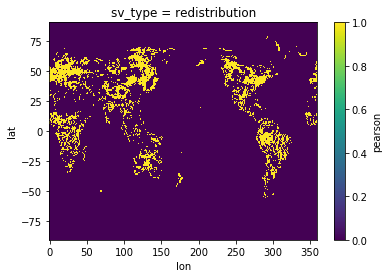

In [67]:
sv_mask[corType].isel(sv_type=1).plot(robust=True);
print(svd2.where(svd2.varfrac>0).sel(lat=slice(a[0],b[0]), lon=slice(c,d)) )

In [68]:
# make plots for regions as in Buermann et al. 2018 
a = [50, 50 ]  # siberia = 60-70N, 80-120E
b = [60, 60 ]  # W US    = 40-50N, 105-120W, here W canada instead
c = [125, 230]  
d = [160,270]  
for i in ([0]):
    print('starting plot ' + str(i) )
    mean_svd_plotA = svd_plot.sel(lat=slice(a[i],b[i]), lon=slice(c[i],d[i])).mean(('lat','lon')) 
    mean_svd_plotB = svd_plot.sel(lat=slice(a[(i+1)],b[(i+1)]), lon=slice(c[(i+1)],d[(i+1)])).mean(('lat','lon')) 

    monthly_plots(mean_svd_plotA,mean_svd_plotB, a0=c[i], b0=d[i],a1=c[(i+1)], b1=d[(i+1)],  panel=[panel[i], panel[(i+1)]])


starting plot 0


<Figure size 432x324 with 0 Axes>

### Seems to:
* Appropriately identify and reclassify amplification and early phase vectors
* SV1 explians good deal varriation (at least for high & mid latitudes)
* SV2 of redistribution = amplificaiton!
* maybe additional work needed for tropics?
* check that flipping theta values is appropriate?

<xarray.Dataset>
Dimensions:      (lat: 192, lon: 288, sv: 2, time: 12, year: 55)
Coordinates:
  * time         (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * year         (year) int64 1960 1961 1962 1963 1964 ... 2011 2012 2013 2014
  * lat          (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon          (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * sv           (sv) <U14 'amplification' 'redistribution'
Data variables:
    theta        (sv, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    varfrac      (sv, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    vectors      (sv, time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    weights      (sv, year, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    climatology  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan


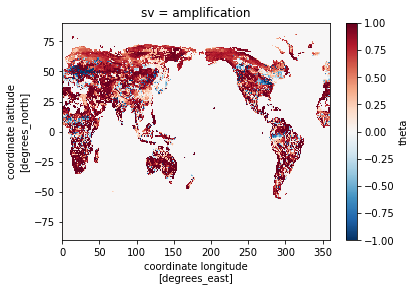

In [69]:
svd2.theta.isel(sv=0).plot(robust=True);
print(svd2)

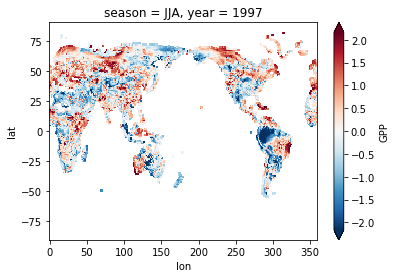

In [70]:
# calculate z-score, which will normalize for differences in SD of raw data
# z = anomaly / sigma (here done for each season)

dt_Z = dt_anom / dt_SD
dt_Z.GPP.isel(season=2, year=37).plot(robust=True);

### Now look for correlations for GPP sv weights & seasonal Anomalies
* Need to flip SH results back to Jan-Dec ordering for seasonal comparisions

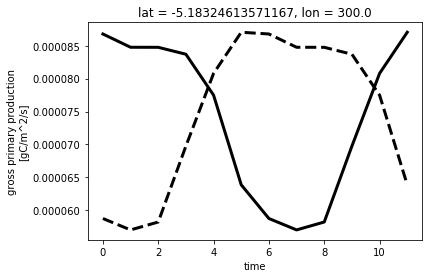

In [71]:
idx = [6,7,8,9,10,11,0,1,2,3,4,5]
svdSH = svd2.copy(deep=True)
svdSH = svdSH.reindex(time=idx)
svdSH['time'] = svd2.time

tlat = -5  #60, 70 #-5  #46  #-3
tlon = 300 #240,30 #300 #262 #280
svd2.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='k',lw=3,ls='--')
svdSH.climatology.sel(lat=tlat, lon=tlon, method='nearest').plot(color='k',lw=3);

In [72]:
# Replace SH values with those w/ reindexed time
svd2 = svdSH.where(svdSH.lat<0, svd2)

# Create correlation matrix with flipped SV weights & vectors with monthly anomalies
# first make year dimensions indential
svd2['year'] = dt_anom.get('year')
dt_Z['year'] = dt_anom.get('year')

# correlation of anomalies with modified (flipped SVD results)
# corr_wrap seasonal anomalies ~ svd.weights for SV1 [amplification] & SV2 [early shift]
svd_corr = corr_wrap(dt_anom, svd2)
svd_Zcorr = corr_wrap(dt_Z, svd2)

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, season: 4, sv: 2)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * sv       (sv) object 'amplification' 'redistribution'
Data variables:
    TWS      (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    TBOT     (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    NEP      (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    GPP      (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ER       (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    FSDS     (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    SFCO2    (sv, season, lat, lon) float64 nan nan nan nan ... nan nan nan nan


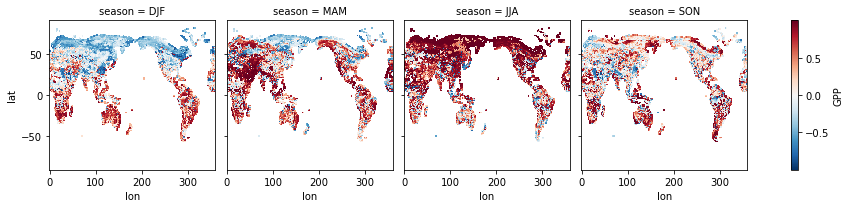

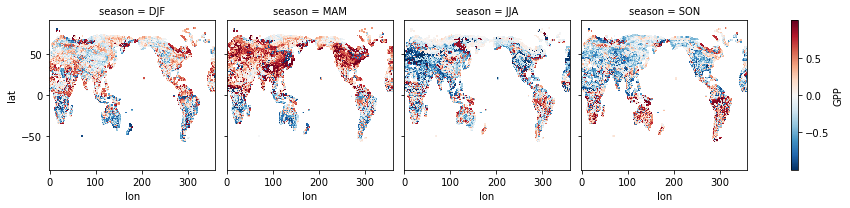

In [73]:
#print(svd2)
print(svd_corr)
# --- Check that results ar sensible ---
# GPP SV1 coorelated with JJA GPP anomalies in NH, as expected
# GPP SV1 coorelated with MAM GPP anomalies in early shift regions (NE USA + Ag.) 
for i in range(2):
    simple = svd_corr.GPP.isel(sv=i).plot(x='lon', y='lat', col='season', col_wrap=4)
#svd_corr.GPP.isel(sv=0, season=2).plot(robust=True);

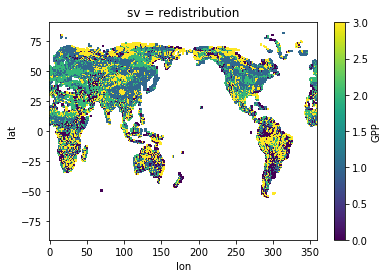

In [74]:
maxGPP_season.isel(sv=1).plot(robust=True);

## Next should look at environmental correlations in dominant seasons
cor.svd[weights] ~ TBOT and TWS anomalies


<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, sv: 2)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * sv       (sv) object 'amplification' 'redistribution'
Data variables:
    TWS      (sv, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TBOT     (sv, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    NEP      (sv, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    GPP      (sv, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ER       (sv, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    FSDS     (sv, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SFCO2    (sv, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0


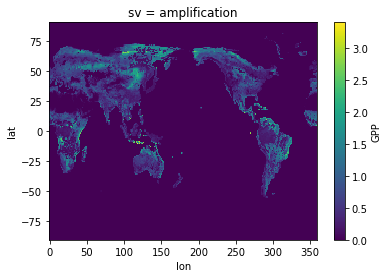

In [75]:
## simplify correlations to look at values only when 
# weights from SV most strongly correlate with seasonal GPP anomalies

# 1) set up dataset to hold results
max_season_corr = xr.Dataset( coords={'sv': SVtype , "lat": ds.lat, "lon": ds.lon} )
max_season_SD   = xr.Dataset( coords={'sv': SVtype ,"lat": ds.lat, "lon": ds.lon} )
max_season_wgt  = xr.Dataset( coords={'sv': SVtype ,'year':dt_anom.year, "lat":dt_anom.lat, "lon":dt_anom.lon} )
max_season_Z    = xr.Dataset( coords={'sv': SVtype ,'year':dt_anom.year, "lat":dt_anom.lat, "lon":dt_anom.lon} )
corr_shape = (2, ) + yx_shape 

for i in range(len(var)):
    max_season_corr[var[i]] = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))
    max_season_SD[var[i]]   = xr.DataArray(np.zeros(corr_shape), dims=('sv','lat', 'lon'))
    max_season_wgt[var[i]]  = xr.DataArray(np.zeros((2, years, dims['lat'], dims['lon'])), 
                                           dims=('sv','year','lat', 'lon'))
    max_season_Z[var[i]]  = xr.DataArray(np.zeros((2, years, dims['lat'], dims['lon'])), 
                                           dims=('sv','year','lat', 'lon'))

print(max_season_SD)

# 2) loop through vectors and seasons
# write out corr coefficients where maxGPP_seaon == T
for i in range(len(SVtype)):         # vectors
      for j in range(len(seasonName)): # seasons
            for k in range(len(var)):
                max_season_corr.get(var[k])[i,...] = svd_corr.get(var[k])[i,j,...].where(maxGPP_season[i,...]==j, 
                                                                                             max_season_corr.get(var[k])[i,...])
                max_season_SD[var[k]][i,...] = dt_anomSD.get(var[k])[j,...].where(maxGPP_season[i,...]==j,
                                                                           max_season_SD.get(var[k])[i,...])
                max_season_wgt[var[k]][i,...] = dt_anom.get(var[k])[j,...].where(maxGPP_season[i,...]==j,
                                                                           max_season_wgt.get(var[k])[i,...])
                max_season_Z[var[k]][i,...] = dt_Z.get(var[k])[j,...].where(maxGPP_season[i,...]==j,
                                                                           max_season_Z.get(var[k])[i,...])

#convert C flux anomalies to gC/m2/d 
max_season_wgt['GPP'] = max_season_wgt.GPP * 3600 * 24 
max_season_SD['GPP'] = max_season_SD.GPP * 3600 * 24 
max_season_wgt['NEP'] = max_season_wgt.NEP * 3600 * 24 
max_season_SD['NEP'] = max_season_SD.NEP * 3600 * 24 

max_season_SD.GPP.isel(sv=0).plot();

In [76]:
# from scipy.statss 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html#scipy.stats.pearsonr
# to test for significance, find critical values for n=55 

#       (1 - r**2)**(n/2 - 2)
# f(r) = ---------------------
#          B(1/2, n/2 - 1)

# where  beta =  dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)

# p = 2*dist.cdf(-abs(r))
n = len(svd2.year)
dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
r = 0.266
p = 2*dist.cdf(-abs(r))
p

0.049655463647177836

## For this example (n=55), |r|> 0.266 is significnt
for n = 110 (two representative grids) |r|>0.19 is significant

amplification


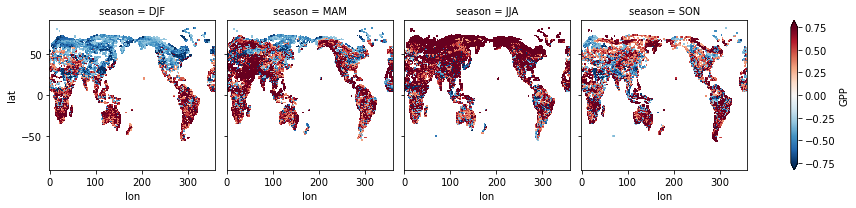

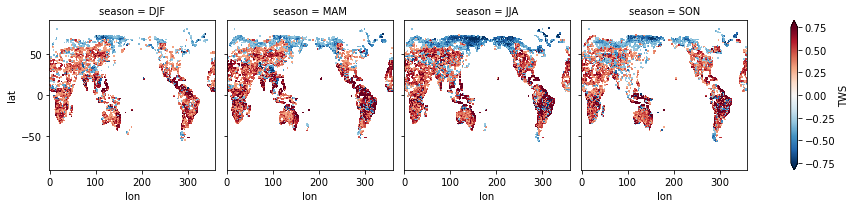

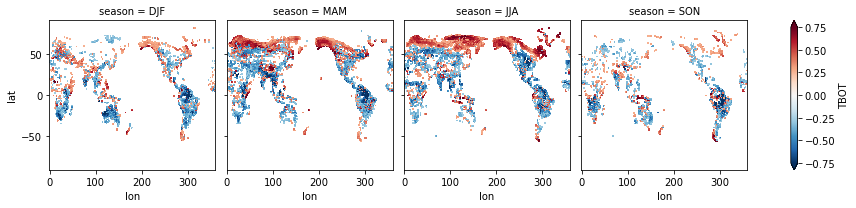

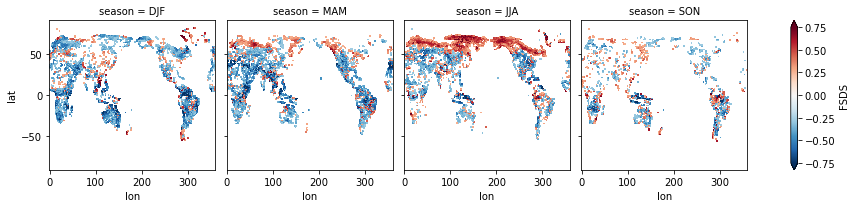

In [77]:
# use xarray facet plots for pannels
# each row show correlations between SV_1 weights and seasonal anomalies
# mask out grids that are not signficant

plotVar = ['GPP','TWS','TBOT','FSDS']
h=0
print(svd_corr.sv[h].values)
svd_corrMask =  xr.ufuncs.fabs(svd_corr)
svd_corr = svd_corr.where(svd_corrMask>r) 

for k in range(len(plotVar)):
    simple = svd_corr[plotVar[k]].isel(sv=h).plot(x='lon', y='lat', col='season', col_wrap=4,
                                                 cmap='RdBu_r', vmax=0.75, vmin=-0.75)
    


redistribution


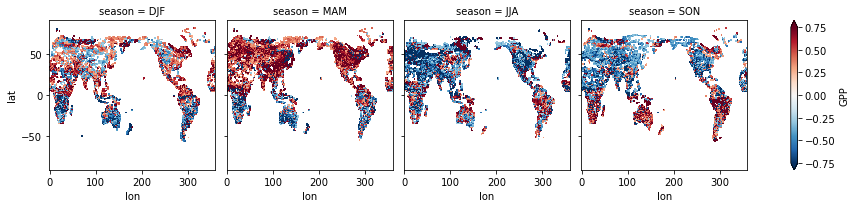

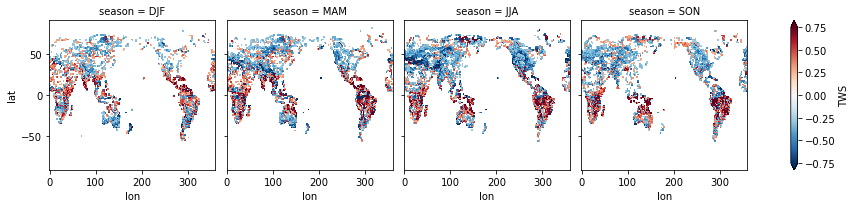

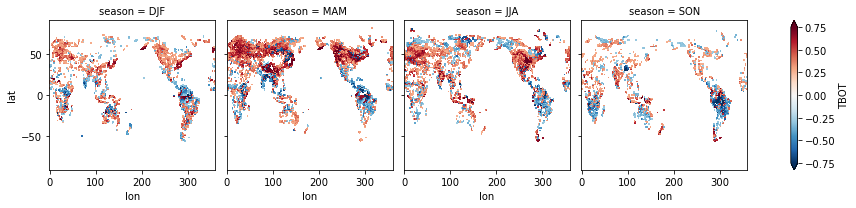

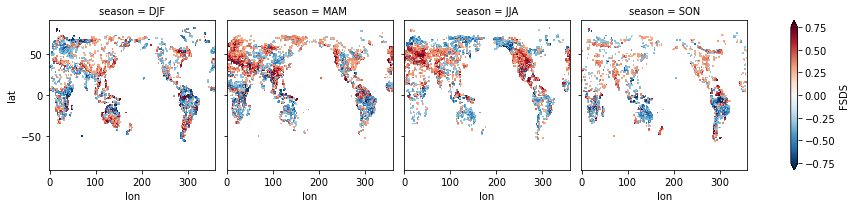

In [78]:
print(svd_corr.sv[1].values)
for k in range(len(plotVar)):
    simple = svd_corr[plotVar[k]].isel(sv=1).plot(x='lon', y='lat', col='season', col_wrap=4, 
                                                  cmap='RdBu_r', vmax=0.75, vmin=-0.75)

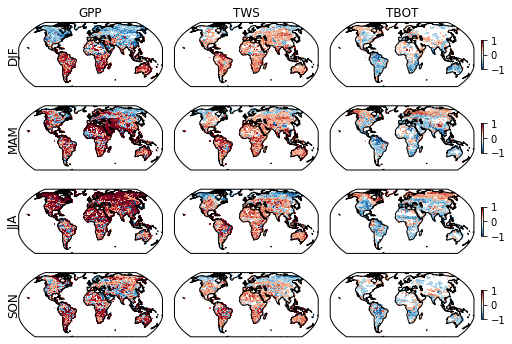

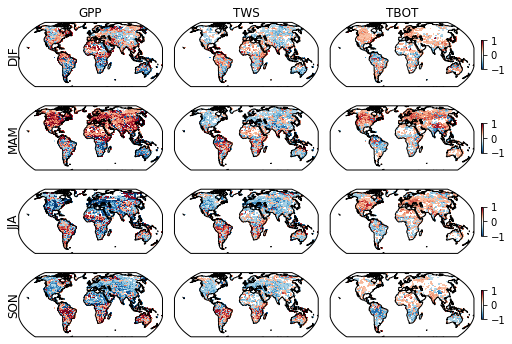

In [79]:
# This repeats above in a different way
# The files  written out are HUGE, > 100 MB. Is there some way to lower resolution?
plotVar = ['GPP','TWS','TBOT']
for h in range(len(SVtype)):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(7,4.8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
    for index, ax in np.ndenumerate(axes):
        i = index[1] 
        j = index[0] 
        da = svd_corr[plotVar[i]].isel(sv=h, season=j)
        cmap='RdBu_r'
        vmax=1.0
        vmin=-1.0
        if j == 0: title = plotVar[i]
        else: title=None
            
        if i == 0:  ax.annotate(str(da.coords['season'].values), xy=(-0.035, 0.5), xycoords=ax.transAxes,
                                ha='center', va='center',fontsize=12, rotation=90)    

        if i == 2: cb=1
        else: cb=0

        map_function(da, ax=ax, title=title, cmap=cmap, vmax=vmax, vmin=vmin,cb=cb)

    #plt.subplots_adjust(bottom=0.01, top=0.96,
    #                    left=0.04, right=0.96, wspace=0.01)
    #plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_'+str(h+6)+'_'+SVtype[h]+'_seasonal_summary.eps', dpi=300)

['GPP', 'TWS', 'TBOT']


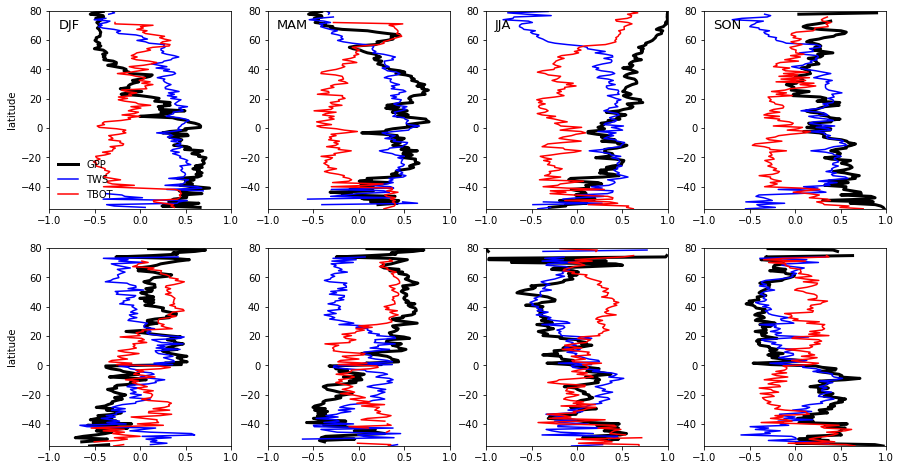

In [80]:
# try reducing dimensions somehow, maybe  zonal means  of correlations coeff by season
print(plotVar)
col = ['k','b','r']
wt = [3,1.5,1.5]
#legend =('GPP' ,'TWS','TBOT')
plt.figure(figsize=[15,8])
p = 0
for h in range(2):
    for i in range(4):
        p = p +1
        plt.subplot(2,4,p)
        plt.xlim(-1, 1)
        plt.ylim(-55,80)
        for j in range(3):
            yVar  = svd_corr[plotVar[j]].isel(sv=h, season=i).mean(dim='lon')
            plt.plot(yVar,svd_corr.lat.values,  col[j], lw=wt[j])

        if i  == 0:
            plt.ylabel('latitude')
        if h == 0:
            plt.text(0.05, 0.93,svd_corr.season[i].values, fontsize=13, 
                     ha='left', va='center', transform=plt.gca().transAxes)
            if i == 0:
                plt.legend(labels=plotVar, frameon=False, loc='lower left')

    #plt.legend(labels=labels);
    #plt.title('SVD tlat='+str(tlat)+' tlon='+str(tlon))
    #plt.ticklabel_format(axis='y', style='', scilimits=(-2,2))


### Correlations still too hard  to visualize, making a matrix of zonal mean results

In [81]:
# first calculate mean of r values across lat bands
zone = ['NH high', 'NH mid','NH low',  'SH low', 'SH mid']
Seasons = ['DJF','MAM','JJA','SON']
svd_corr_mean  = xr.Dataset( coords={'zone':zone,'sv': SVtype , 'season':svd_corr.season})
mean_shape = (5, 2, 4)

for i in range(len(var)):
    svd_corr_mean[var[i]] = xr.DataArray(np.zeros(mean_shape), dims=('zone','sv','season'))

#print(svd_corr_mean)
#print(svd_corr_mean)    
a = [50, 20,  0,-20,-50]  # Min lat, -20 to 10 for Amazon
b = [80, 50, 20,  0, -20]   # Max lat

for h in range(2):
    for i in range(len(a)):
        corTemp  = svd_corr.isel(sv=h).where(sv_mask[corType].isel(sv_type=h)) \
            .sel(lat=slice(a[i],b[i])).mean(('lat','lon'))
        for j in range(len(var)):
            svd_corr_mean[var[j]][i,h,...] = corTemp[var[j]]
    
            
print(svd_corr_mean.GPP.isel(zone=0, sv=0))
print(svd_corr_mean)

<xarray.DataArray 'GPP' (season: 4)>
array([-0.45130025,  0.2230201 ,  0.94926629,  0.41038118])
Coordinates:
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
    sv       <U13 'amplification'
    zone     <U7 'NH high'
<xarray.Dataset>
Dimensions:  (season: 4, sv: 2, zone: 5)
Coordinates:
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * sv       (sv) object 'amplification' 'redistribution'
  * zone     (zone) object 'NH high' 'NH mid' 'NH low' 'SH low' 'SH mid'
Data variables:
    TWS      (zone, sv, season) float64 -0.05104 -0.1684 ... 0.07605 0.09563
    TBOT     (zone, sv, season) float64 0.2121 0.3818 0.3807 ... -0.1118 -0.2241
    NEP      (zone, sv, season) float64 -0.4753 -0.05165 ... 0.1177 0.3342
    GPP      (zone, sv, season) float64 -0.4513 0.223 0.9493 ... 0.1276 0.2802
    ER       (zone, sv, season) float64 -0.3545 0.3216 0.8574 ... 0.1262 0.2247
    FSDS     (zone, sv, season) float64 -0.2438 0.1731 ... -0.1978 -0.2054
    SFCO2    (zone, sv, season) float6

In [82]:
from scipy import stats
# not try calculating stats for all grids w/in lat bands

svd_zone_p  = xr.Dataset( coords={'zone':zone,'sv': SVtype , 'season':svd_corr.season})
svd_zone_R  = xr.Dataset( coords={'zone':zone,'sv': SVtype , 'season':svd_corr.season})
mean_shape = (5, 2, 4)

for i in range(len(plotVar)):
    svd_zone_p[plotVar[i]] = xr.DataArray(np.zeros(mean_shape), dims=('zone','sv','season'))
    svd_zone_R[plotVar[i]] = xr.DataArray(np.zeros(mean_shape), dims=('zone','sv','season'))

for h in range(len(SVtype)):                 # loop  over sv_tpype
    print('starting ' +SVtype[h])
    for i in range(len(zone)):               # loop over lat bands
        for j in range(len(plotVar)):        # loop over variables
            x = svd2['weights'].isel(sv=h).sel(lat=slice(a[i],b[i]))   # subset weights from svd
            y = dt_anom[plotVar[j]].sel(lat=slice(a[i],b[i]))          # subset var from seasonal anom

            for k in range(len(Seasons)):    #loop over seasons        
                y1 = y.isel(season=k).values.ravel()
                R, p = stats.pearsonr(x.values.ravel(), y1)
                svd_zone_p[plotVar[j]][i,h,k] = p
                svd_zone_R[plotVar[j]][i,h,k] = R
            
print(svd_zone_p)

starting amplification
starting redistribution
<xarray.Dataset>
Dimensions:  (season: 4, sv: 2, zone: 5)
Coordinates:
  * season   (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * sv       (sv) object 'amplification' 'redistribution'
  * zone     (zone) object 'NH high' 'NH mid' 'NH low' 'SH low' 'SH mid'
Data variables:
    GPP      (zone, sv, season) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TWS      (zone, sv, season) float64 0.7135 0.0 0.0 ... 2.747e-98 0.0
    TBOT     (zone, sv, season) float64 1.104e-313 0.0 0.0 ... 0.08304 0.0


In [83]:
# choose if we plot correlation mean across grids or R calculated from all points w/in region
for i in range(1):    
    corr = svd_corr_mean[plotVar].isel(sv=i).drop('sv').to_dataframe().unstack(level='season')
    #corr = svd_zone_R[plotVar].isel(sv=i).drop('sv').to_dataframe().unstack(level='season')
    index = [plotVar, Seasons]
    #print(index)
    corr.columns.names = [SVtype[i],corr.columns.names[1]]
    mi = pd.MultiIndex.from_product([plotVar, Seasons], names=[SVtype[i], 'season'], sortorder=None)
    corr = corr.reindex(mi, axis=1)
    corr = corr.reindex(zone, axis=0)
    #corr = corr.where(abs(corr)>r,0)
    corr_table = corr.style.background_gradient(cmap='BrBG',axis=None).set_precision(2)
    # 'coolwarm', RdBu_r' & 'BrBG' are other good diverging colormaps
    with pd.ExcelWriter('/glade/scratch/wwieder/svd/'+model+'/'+model+'corr_table'+str(i)+'.xlsx' ) as writer:
        corr_table.to_excel(writer)

corr_table

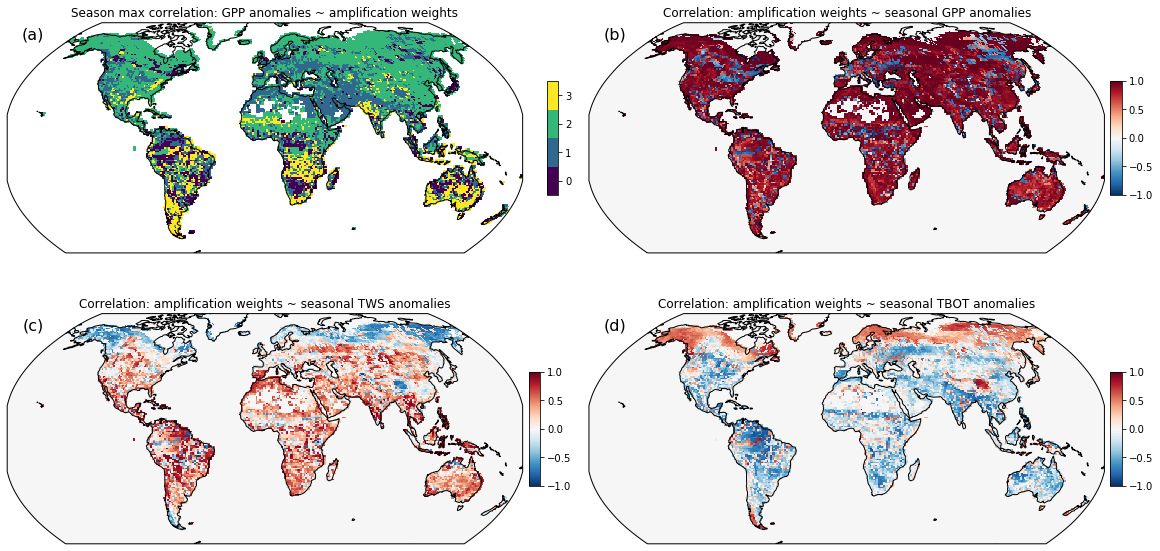

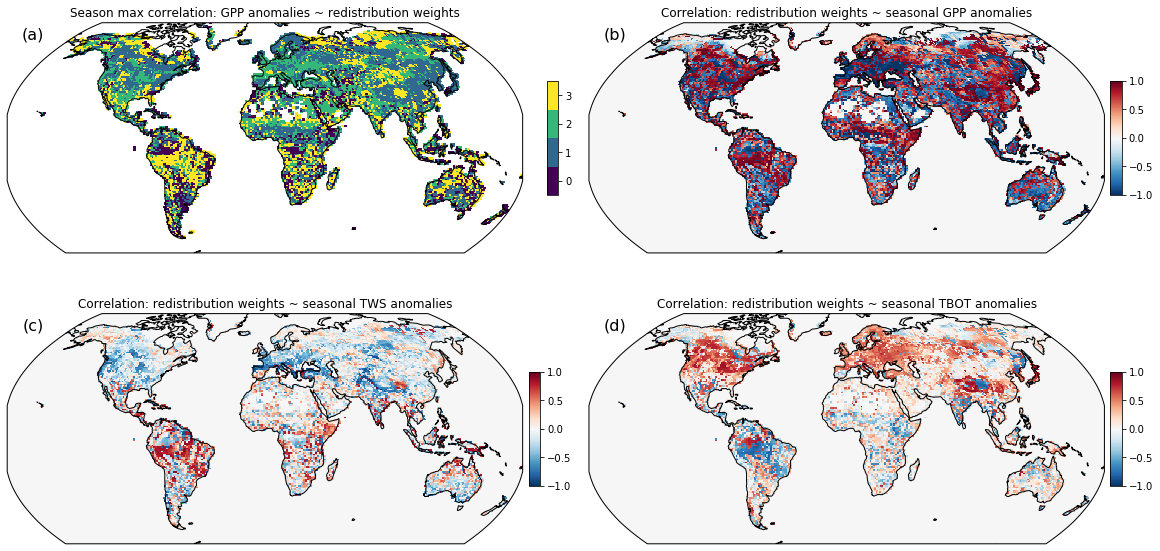

In [84]:
# -- first add season of max correlation of SV weights with GPP anomalies to dataset being plotted
max_season_corr['maxGPP_season'] = maxGPP_season
max_season_SD['maxGPP_season'] = maxGPP_season  
var2 = ['maxGPP_season']+['GPP','TWS','TBOT']
# Now call the map_function
for h in range(len(SVtype)):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), constrained_layout=True,
                             subplot_kw=dict(projection=ccrs.Robinson()))

    i = 0
    for index, ax in np.ndenumerate(axes):
        # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
        da = max_season_corr[var2[i]].isel(sv=h)
        if i == 0:
            #Can I ake these arguments a list or a dictionary?
            cmap = plt.get_cmap("viridis",4)
            vmax=3.5
            vmin=-0.5
            title='Season max correlation: GPP anomalies ~ '+SVtype[h]+' weights'
        else: 
            cmap='RdBu_r'
            vmax=1
            vmin=-1
            title='Correlation: '+SVtype[h]+' weights ~ seasonal '+var2[i]+' anomalies'
        map_function(da, ax=ax, panel=panel[i], title=title, cmap=cmap, vmax=vmax, vmin=vmin,cb=1)
        i = i+1

    plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_'+SVtype[h]+'_summary.eps')
    

In [85]:
R, p = stats.pearsonr(x,y)

ValueError: x and y must have the same length.

#### Grids characterized by amplification SV also have higher % varriation explianted by soil water
#### Early phase harder to interpret this way,  w/  patchwork of +/- GPP correlations

In [ ]:
sv_mask['pearson'].plot(x='lon', y='lat', col='sv_type', col_wrap=2);

In [ ]:
# Sub set where SV1 [redistribution] = dominant 
svType = 1

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
i = 0
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = max_season_corr[var2[i]].isel(sv=svType).where(sv_mask[corType].isel(sv_type=svType))
    if i == 0:
        #Can I ake these arguments a list or a dictionary?
        cmap = plt.get_cmap("viridis",4)
        vmax=3.5
        vmin=-0.5
        title='season max corr. phase weights & GPP anomalies'
    else: 
        cmap='RdBu_r'
        vmax=0.7
        vmin=-0.7
        title='correlation '+str(sv_mask.sv_type[svType].values)+' weights & '+var2[i]+' anomalies '
    map_function(da, ax=ax, title=title, cmap=cmap, vmax=vmax, vmin=vmin,cb=1)
    i = i+1

In [ ]:
# Look at GPP for JJA and SON when SV1 = redistribution in NH

In [ ]:
pvar = ['GPP','TWS','TBOT']
for v in range(len(pvar)):
    plt.figure(figsize=[20,3])
    for i in range(2):
        plt.subplot(1,4,(i+1))
        svd_corr[pvar[v]].isel(sv=0, season=2).where(sv_mask[corType].isel(sv_type=i)).plot(robust=True)

    plt.subplot(1,4,3)
    svd_corr[pvar[v]].isel(sv=0, season=1).where(sv_mask[corType].isel(sv_type=1)).plot(robust=True)
    plt.subplot(1,4,4)
    svd_corr[pvar[v]].isel(sv=0, season=3).where(sv_mask[corType].isel(sv_type=1)).plot(robust=True)
    plt.subplots_adjust(wspace=0.25);

In [ ]:
print(sv_mask.sv_type[0].values)

In [ ]:
# Now call the map_function
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))

i = 0
for index, ax in np.ndenumerate(axes):
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = max_season_corr[var2[i]].isel(sv=0)
    if i == 0:
        #Can I ake these arguments a list or a dictionary?
        cmap = plt.get_cmap("viridis",4)
        #cmap = colors.ListedColormap(['r', 'g', 'b', 'c'])
        vmax=3.5
        vmin=-0.5
        title='month max correlation SVD1 weights & GPP anomalies'
    else: 
        cmap='RdBu_r'
        vmax=1
        vmin=-1
        title='correlation SV1 Weights ~ seasonal '+var2[i]+' anomalies'
    map_function(da, ax=ax, title=title, cmap=cmap, vmax=vmax, vmin=vmin,cb=1)
    i = i+1
     

### Makes more sense to correlate anomalies or z-score directly?
#### use ufunc to to apply linear regression & save output


In [ ]:
# output = slope, intercept, r, p, SE
def reg3d(x, y):
    reg = xr.apply_ufunc(scipy.stats.linregress, x, y,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[[], [], [], [], []],
        vectorize=True,  dataset_join='exact')
    return reg

reg_shape = (2,5, ) + yx_shape
types = ['anomaly','z-score']
lin_out = ['slope', 'intercept', 'r','p', 'SE']
reg_out = xr.Dataset( coords={'type':types,'lin_reg':lin_out, "lat": ds.lat, "lon": ds.lon} )

for i in range(2):
    reg_out[var[i]] = xr.DataArray(np.zeros(reg_shape), dims=('type','lin_reg','lat', 'lon'))
    temp0 = reg3d(max_season_wgt.get(var[i]),max_season_wgt.get('GPP'))
    temp1 = reg3d(max_season_Z.get(var[i]),max_season_Z.get('GPP'))
    print(temp0)# not sure how to get series of 5 arrays into dataset, but this works
    for j in range(5):
        print(var[i])
        reg_out[var[i]][0,j,...] = temp0[j] 
        reg_out[var[i]][1,j,...] = temp1[j] 

print(reg_out)

In [ ]:
reg_outSig = reg_out.where(reg_out.isel(lin_reg=3)<0.05)
#reg_outSig.TBOT.isel(type=0, lin_reg=0).plot(robust=True);

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
imax = [0.02, 0.5] #slope ranges for TWS, TBOT
imin = [-0.02, -0.5]
for index, ax in np.ndenumerate(axes):
    print(index)
    i = index[0]
    j = index[1]
    da = reg_outSig[var[(j+0)]].isel(lin_reg=0, type=i) #lin_reg [0 = slope], [2 = r]
    title='slope GPP ~ '+var[(j+0)]+' '+types[i]
    if j == 0:
        cmap='RdBu'
        #cmap='BrBG'
    else:
        cmap='RdBu_r'
    if i == 0:
        #vmax=1.
        #vmin=-1.
        vmax=imax[j]
        vmin=imin[j]
    else:
        vmax=1.
        vmin=-1.

    map_function(da, ax=ax, title=title, cmap=cmap, vmax=vmax, vmin=vmin,cb=1)

#plt.savefig('/glade/scratch/wwieder/svd/'+model+'_regressionR.pdf')

# HERE make a plot like this with annual anomalies!

# unused code, here to work on flipping vectors / weights

In [ ]:
## Code below may not be most appropriate, comment out for now
print(np.sqrt(0.4877))
'''corType = 'weighted'

# This selects amplification vectors, where correlation coef. negative
# reverses weights and vectors for amplitde SVs as needed
flip_corr = 0+(GPP_corr[corType] < 0.)
flip_corr[0,:,:] = flip_corr[0,:,:].where(sv_mask[corType].isel(sv_type=0), 0) 
flip_corr[1,:,:] = flip_corr[1,:,:].where(sv_mask[corType].isel(sv_type=1), 0)
print(flip_corr.sel(lat=tlat, lon=tlon, method='nearest'))
#flip_corr.isel(sv=0).plot()

# Still need a better way to think about flipping early phase vectors where needed...
# currently selects when minimum month comes before max & reverses early shift SV
max_vector = svdGPP.vectors.argmax(dim='time') 
min_vector = svdGPP.vectors.argmin(dim='time') 
flip_vector = 0+(min_vector < max_vector)
flip_vector[0,:,:] = flip_vector[0,:,:].where(sv_mask[corType].isel(sv_type=1),0)
flip_vector[1,:,:] = flip_vector[1,:,:].where(sv_mask[corType].isel(sv_type=0),0)
print(flip_vector.sel(lat=tlat, lon=tlon, method='nearest'))

flip_combined = flip_corr + flip_vector 
flip_combined.isel(sv=0).plot()
print(flip_combined.sel(lat=tlat, lon=tlon, method='nearest'))

## create new datasets that don't change the orig. results
svd2 = svdGPP.copy(deep=True) 
for i in range(years):
    svd2.vectors[i,...] = svd2.vectors[i,...].where(flip_combined[i,...] <= 0, -1*svd2.vectors[i,...])
    svd2.weights[i,...] = svd2.weights[i,...].where(flip_combined[i,...] <= 0, -1*svd2.weights[i,...])'''

# add one more logical for if amplication vectors 
''' NOT USED HERE
# Here if mean vectors < 0 flip vectors & weights for Amp. SV 
flip_amp =  svd2.vectors.mean(dim='time') < 0.
for i in range(2):
    flip_amp[i,:,:] = flip_amp[i,:,:].where(sv_mask[corType].isel(sv_type=i),0)

flip_amp.isel(sv=0).plot(robust=True)
print(svd2.vectors.mean(dim='time').sel(lat=tlat, lon=tlon, method='nearest'))
print(flip_amp.sel(lat=tlat, lon=tlon, method='nearest'))
'''

'''
# select grids where max vector is negative to reverse weights and vector for amp. SV
flip_max =  svd2.vectors.max(dim='time') < 0.
for i in range(2):
    flip_max[i,:,:] = flip_max[i,:,:].where(sv_mask[corType].isel(sv_type=i),0)

flip_max.isel(sv=0).plot(robust=True);
print(svd2.vectors.mean(dim='time').sel(lat=tlat, lon=tlon, method='nearest'))
print(flip_max.sel(lat=tlat, lon=tlon, method='nearest'))


for i in range(years):
    svd2.vectors[i,...] = svd2.vectors[i,...].where(flip_max[i,...] <= 0, -1*svd2.vectors[i,...])
    svd2.weights[i,...] = svd2.weights[i,...].where(flip_max[i,...] <= 0, -1*svd2.weights[i,...])

# Now repeat the correlation between vectors and climatology    
'''

'''svd3 = svdGPP.copy(deep=True) 
for i in range(years):
    svd3.vectors[i,...] = svd3.vectors[i,...].where(flip_combined[i,...] <= 0, -1*svd3.vectors[i,...])
    svd3.weights[i,...] = svd3.weights[i,...].where(flip_combined[i,...] <= 0, -1*svd3.weights[i,...])'''

## Look at EOFs for spatial information?

In [ ]:
'''na     = -9999
from eofs.xarray import Eof
NEP    = ds_anom.NEP.fillna(na) 
NEP_dt = signal.detrend(NEP, axis=0,type='linear')

# add back in dims and coords
NEP_dt = xr.DataArray(NEP_dt, coords = ds_anom.NEP.coords, dims = ds_anom.NEP.dims, attrs = ds_anom.NEP.attrs)
# add back in missing values
NEP_dt = NEP_dt.where(NEP != na)  
print(NEP_dt)'''

In [ ]:
'''%%time 
# Create an EOF solver to do the EOF analysis. 
# latitude weights are applied before the computation of EOFs.
solverNBP  = Eof(NBP_dt, weights=l_wt2)'''

In [ ]:
'''# how much of variance does each EOF describe?  
# not much, all are < 10% (except temperature)
ev = solverNBP.varianceFraction(neigs=3)
print(ev)

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input VAR0 anomalies at each grid point, and the
# leading PC time series itself.
eof1_NBP = solverNBP.eofsAsCorrelation(neofs=1)'''